# Descriptive Analysis

This notebook uses the cleaned and prepared taxi data (see data_cleaning.ipynb) as well as data about Chicago's census tracts (boundaries.geojson), weather data (Weather_chig.csv), point-of-interest information and land-use data (census_spatial_features.geojson). 

To be able to run this notebook, please ensure all relevant libraries have been installed. You can do this manually or run the included requirements.txt file by running the following command (needs pip installed): 
pip install -r requirements.txt

# 0 - Imports and Preparation

In [1]:
# import all relevant libraries used during the analysis
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import h3
import geopandas as gpd
from shapely.geometry.polygon import Polygon

In [ ]:
# set file path for all relevant data files
file_path = "./data/" 

In [2]:
# load taxi trip data
taxi_trips_df = pd.read_csv(f"{file_path}clean_taxi_data.csv")

In [3]:
# load census tract data 
boundaries = gpd.read_file(f'{file_path}Boundaries.geojson')
boundaries['census'] = boundaries['geoid10'].astype('int64')

# calculate the centroid of each hexagon
boundaries['centroid'] = boundaries['geometry'].apply(lambda x: x.centroid)

In [4]:
# convert date-related columns to datetime
taxi_trips_df['start_day'] = pd.to_datetime(taxi_trips_df['start_day'])
taxi_trips_df['end_day'] = pd.to_datetime(taxi_trips_df['end_day'])
taxi_trips_df['trip_start'] = pd.to_datetime(taxi_trips_df['trip_start'])
taxi_trips_df['trip_end'] = pd.to_datetime(taxi_trips_df['trip_end'])

## Data Preparation for H3 Hexagons 

Instead of only using census tract level data, we also consider H3 hexagons. They are a type of grid system used for mapping and analyzing spatial data, developed by Uber. They divide the world into a series of hexagon-shaped cells, which are all of the same size to faciilitate the comparison and visualization of geographic information.

In [5]:
# filter columns
boundaries = boundaries.filter(['census', 'geometry', 'centroid'])

# calculate hexagon ID for resolution 4-9
for i in range(4, 10):
    boundaries[f'h3_{i}'] = boundaries['centroid'].apply(
        lambda centroid: h3.geo_to_h3(centroid.y, centroid.x, resolution=i))

    # calculate the geometry of the hexagons
    boundaries[f'geometry_h3_{i}'] = boundaries.apply(
        lambda x: Polygon(h3.h3_to_geo_boundary(x[f'h3_{i}'], geo_json=True)), 
        axis=1
    )

    # calculate the centroid of each hexagon
    boundaries[f'centroid_h3_{i}'] = boundaries[f'geometry_h3_{i}'].apply(lambda x: x.centroid)

# 1 - Spatial Analysis

The first thing we want to do is to look at how different features are distributed across the city to get a feeling of how the demand for taxis is spread and whether demand hotspots and patterns can be discovered.

In [6]:
def plot_geodata(data, ax, column, row, col,  label): 
    """Function to plot geospatial data on a given axis.
    
    Args:
        data: GeoDataFrame or DataFrame containing geospatial data to plot.
        ax: List of Matplotlib Axes objects where the plot will be drawn.
        column: Name of the column in the data.
        row: Gives the row of the plot in the subplot.
        column: Gives the column of the plot in the subplot.
        label: Title to set for the plot.

    Returns:
        None
    """
    if np.ndim(ax) == 1:
        # reshape 1D array to 2D
        ax = np.reshape(ax, (1, -1))
    if np.ndim(ax) == 2:
        subplot_ax = ax[row, col]

    # plot the geospatial data on the specified axis 
    plot = data.plot(
        column=column,       
        legend=True,         
        ax=subplot_ax,
        cmap='viridis'      
    )
    
    # set the title of the plot to the specified label
    subplot_ax.set_title(label)

## Trip Count (Pickup and Dropoff) for different spatial resolutions

By looking at how the often trips start and end in different areas we hope to discover potential demand hotspots. These areas should be of high interest to the client when they are starting to establish themselves in the ride-hailing market.  

In [7]:
# group by pickup and dropoff census tracts and count the trips
trip_counts_starting = taxi_trips_df.groupby('pickup_census').size().reset_index(name='census_count')
trip_counts_ending = taxi_trips_df.groupby('dropoff_census').size().reset_index(name='census_count')

# merge counts with census tract boundary data
trip_counts_starting = pd.merge(boundaries, trip_counts_starting, 
                                left_on="census", right_on='pickup_census', how='left')
trip_counts_ending = pd.merge(boundaries, trip_counts_ending, 
                               left_on="census", right_on='dropoff_census', how='left')

# convert the resulting dataframes to geodataframes
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry='geometry')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry='geometry')

In [8]:
# calculate pickup counts for different hexagon resolutions
for i in range (4,10):
    trip_counts_starting[f'pickup_count_{i}'] = trip_counts_starting.groupby(f'h3_{i}')[f'census_count'].transform('sum')

In [9]:
# calculate dropoff counts for different hexagon resolutions
for i in range (4,10):
    trip_counts_ending[f'dropoff_count_{i}'] = trip_counts_ending.groupby(f'h3_{i}')[f'census_count'].transform('sum')

### Trip Count on Census Tract Level

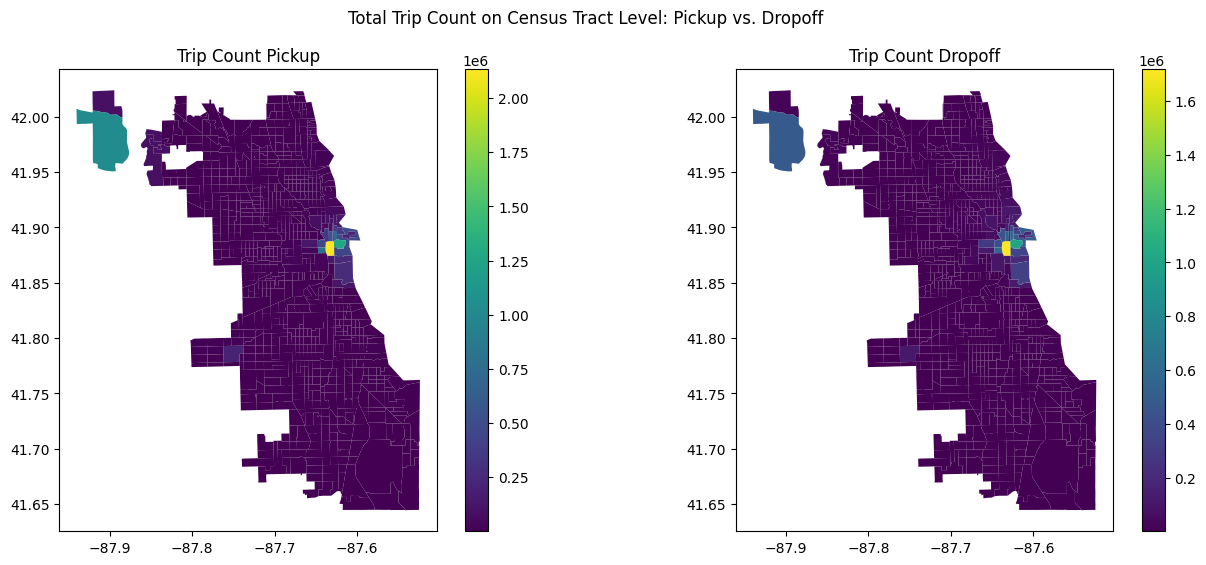

In [10]:
# plot the total number of trips for each census tract, differentiating between pickup and dropoff
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Total Trip Count on Census Tract Level: Pickup vs. Dropoff')

plot_geodata(trip_counts_starting, ax, 'census_count', 0, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'census_count', 0, 1, 'Trip Count Dropoff')


There seems to be a drastic difference in the number of trips when comparing the city centre and the outer city (excluding some special areas in the north west and to a lesser extent one census tract in the west, which are the O'Hare airport and the Midway airport respectively). 

The next figures use the trip counts on a logarithmic scale to be able to better differentiate the busyness in the outer census tracts.

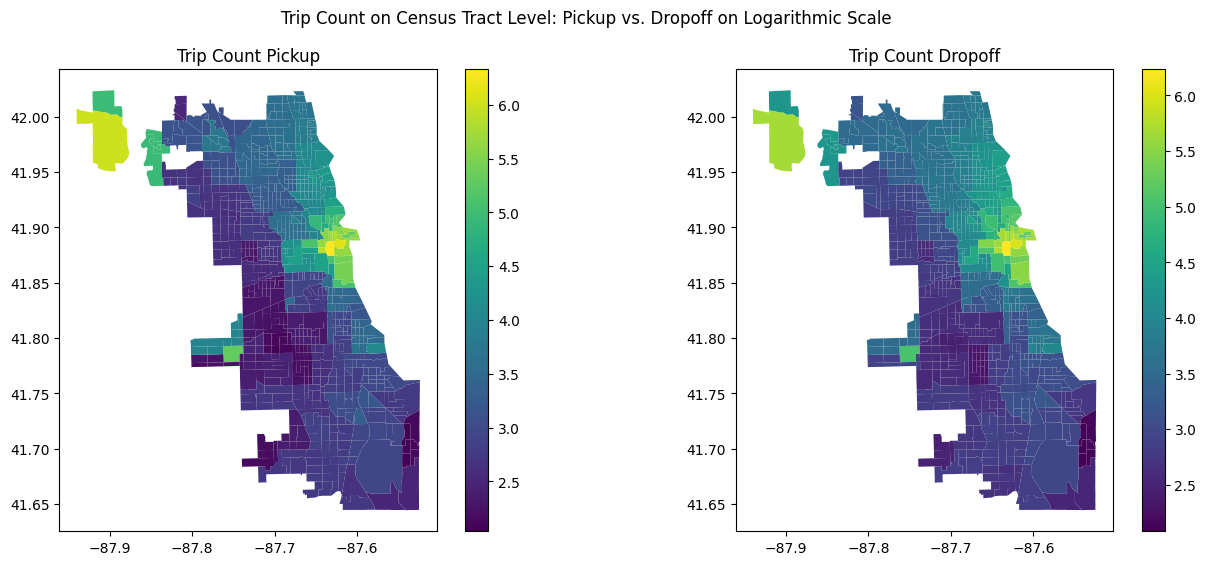

In [11]:
# transform the count on logarithmic scale
trip_counts_starting["census_count_log10"] = trip_counts_starting['census_count'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["census_count_log10"] = trip_counts_ending['census_count'].apply(lambda x: np.log10(x) if x > 0 else 0)

# plot the number of trips for each census tract on logarithmic scale, differentiating between pickup and dropoff
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Trip Count on Census Tract Level: Pickup vs. Dropoff on Logarithmic Scale')

plot_geodata(trip_counts_starting, ax, 'census_count_log10', 0,0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'census_count_log10', 0,1, 'Trip Count Dropoff')

This visualization gives a slightly clearer picture of how the demand is spread across the city, especially for how the lower demand areas which can now be further differentiated. In general it can be deducted that the north of the city has higher demand for both for pickup and dropoff compared to the south. 

In [12]:
# calculate some very basic statistics about the pickup trips
print(f"maximum number of starting trips in a census tract: {trip_counts_starting['census_count'].max()}\naverage number of trips in a census tract: {trip_counts_starting['census_count'].mean()}\nminimum number of trips in a census tract: {trip_counts_starting['census_count'].min()}")
# get how many percentage of rides top ten starting census tracts are 
print((trip_counts_starting.nlargest(10, "census_count")["census_count"].sum()/trip_counts_starting["census_count"].sum()) * 100)
# get how many percentage of rides lowest 100 census starting tracts are 
print((trip_counts_starting.nsmallest(100, "census_count")["census_count"].sum()/trip_counts_starting["census_count"].sum()) * 100)

maximum number of starting trips in a census tract: 2132905
average number of trips in a census tract: 18257.676654182273
minimum number of trips in a census tract: 109
56.23688193955868
0.12150242892032691


In [13]:
# calculate some very basic statistics about the dropoff trips
print(f"maximum number of ending trips in a census tract: {trip_counts_ending['census_count'].max()}\naverage number of trips in a census tract: {trip_counts_ending['census_count'].mean()}\nminimum number of trips in a census tract: {trip_counts_ending['census_count'].min()}")
# get how many percentage of rides top ten dropoff census tracts are 
print((trip_counts_ending.nlargest(10, "census_count")["census_count"].sum()/trip_counts_ending["census_count"].sum()) * 100)
# get how many percentage of rides lowest 100 census dropoff tracts are 
print((trip_counts_ending.nsmallest(100, "census_count")["census_count"].sum()/trip_counts_ending["census_count"].sum()) * 100)

maximum number of ending trips in a census tract: 1718099
average number of trips in a census tract: 17625.995006242196
minimum number of trips in a census tract: 121
47.026686126820685
0.23887230456774844


The numbers above indicate that most trips, pickup and dropoff, concentrate on a very small amount of census tracts. However, the starting trips seem to be even more concentrated, while the end of trips seem to be a bit more diversified. This indicates that people use the taxis to get from these popular places to other popular places but also to get to other parts of the city but not start from there. 

Let's look at these census tracts that account for more than half of all starting and almost half of all ending trips and see if they are the same or not. 

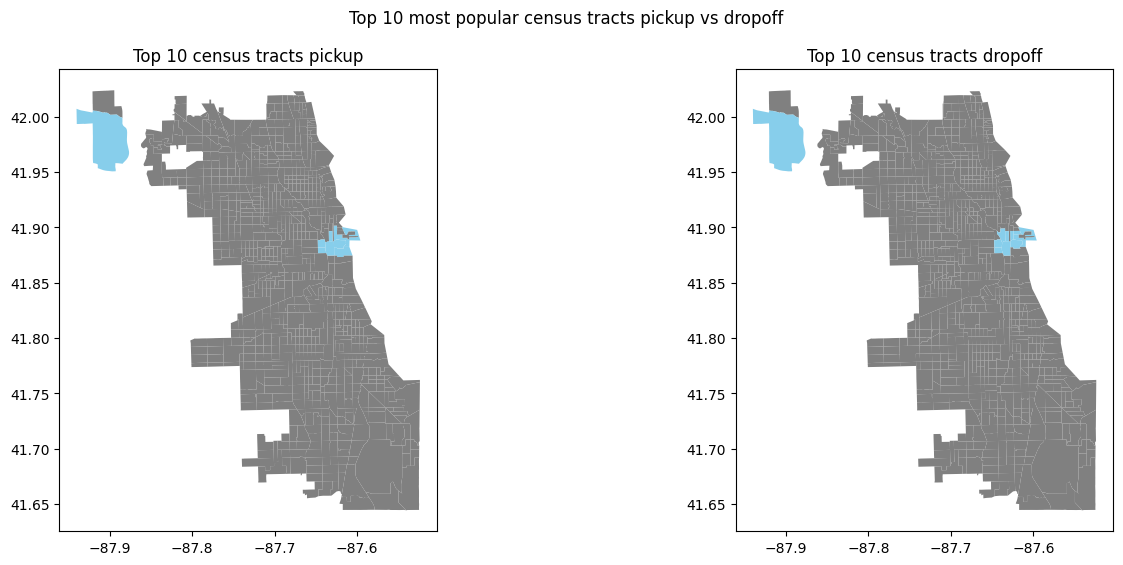

In [14]:
# plot the top 10 starting and ending census tracts
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Top 10 most popular census tracts pickup vs dropoff')

trip_counts_starting.plot(ax=ax[0], color=trip_counts_starting['census'].apply(lambda x: 'skyblue' if x in trip_counts_starting.nlargest(10, 'census_count')['census'].values else 'grey'))
ax[0].set_title('Top 10 census tracts pickup')
trip_counts_ending.plot(ax=ax[1], color=trip_counts_ending['census'].apply(lambda x: 'skyblue' if x in trip_counts_ending.nlargest(10, 'census_count')['census'].values else 'grey'))
ax[1].set_title('Top 10 census tracts dropoff')
plt.show()

The most important census tracts for both pickup and dropoff are concentrated in the same areas, the O'Hare airport and the city centre, with slight variation in the exact census tracts. 

### Trip Ratio Analysis

Let's see if a census tract is rather a starting or ending point for taxi trips. A positive value indicates that the census tract is more of a pickup than a dropoff area. This is important to know when it comes to allocation of vehicles to meet customer demands because areas that are destinations but not starting points will wait a longer for the next customer, hence, are being underutilized, while in starting points there might be a lack of vehicles to meet the demand. Being aware of this inbalance can help better distributing the vehicles across the city. 

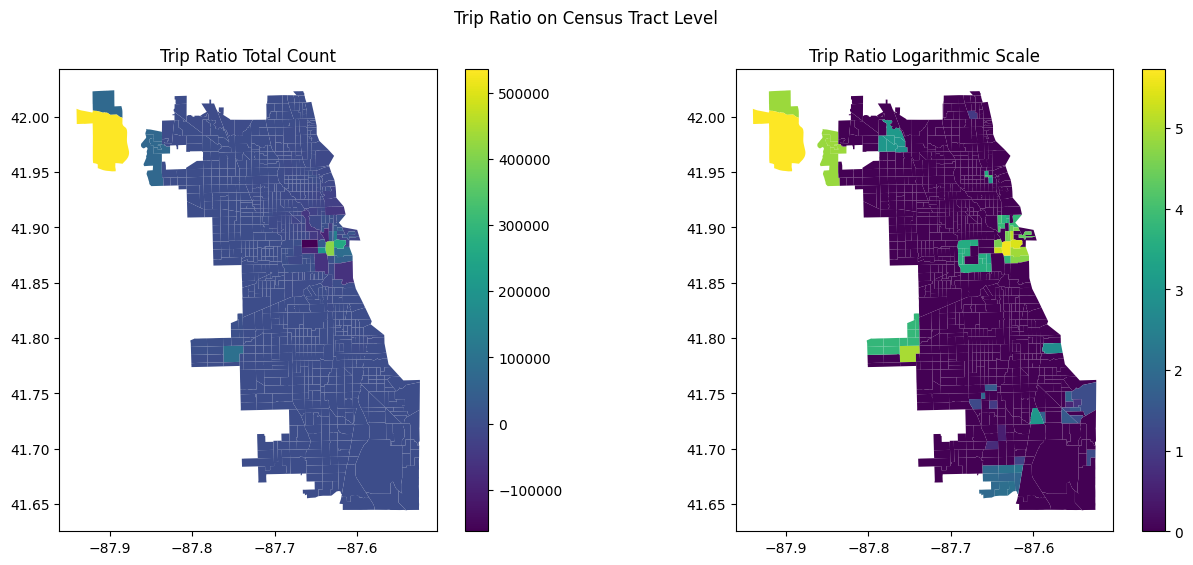

In [15]:
# make dropoff negative and sum both columns 
trip_counts_starting['trips_ratio'] = trip_counts_starting['census_count'] - trip_counts_ending['census_count']
# transform value on logarithmic scale
trip_counts_starting["ratio_log10"] = trip_counts_starting['trips_ratio'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Trip Ratio on Census Tract Level')

plot_geodata(trip_counts_starting, ax, 'trips_ratio', 0,0, 'Trip Ratio Total Count')
plot_geodata(trip_counts_starting, ax, 'ratio_log10', 0,1, 'Trip Ratio Logarithmic Scale')

The O'Hare airport seems to be more of a starting than an ending point, same goes for the city centre. The areas right around the city centre seem to be more popular dropoff locations.


### Trip Count using H3 hexagons (Resolution 4-9)

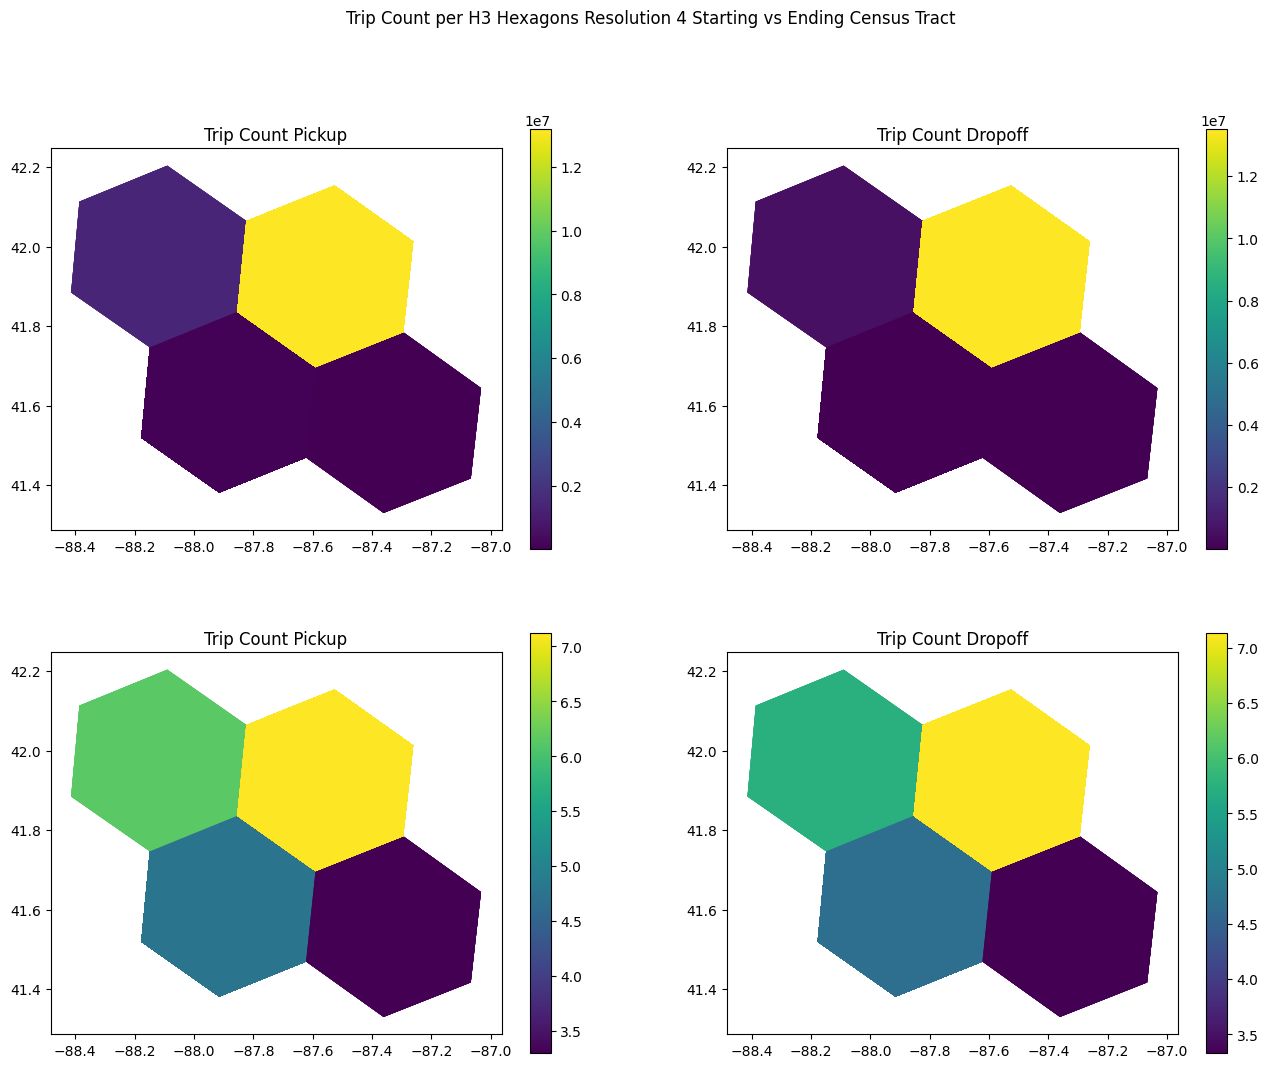

In [16]:
# plot trip count based on h3 hexagons resolution 4 
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 4 Pickup vs Dropoff')
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_4'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_4', 0, 0, 'Trip Count Pickup')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_4'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_4', 0, 1, 'Trip Count Dropoff')

# Transform count
trip_counts_starting["pickup_count_4_log10"] = trip_counts_starting['pickup_count_4'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_4_log10"] = trip_counts_ending['dropoff_count_4'].apply(lambda x: np.log10(x) if x > 0 else 0)


plot_geodata(trip_counts_starting, ax, 'pickup_count_4_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_4_log10', 1, 1, 'Trip Count Dropoff')

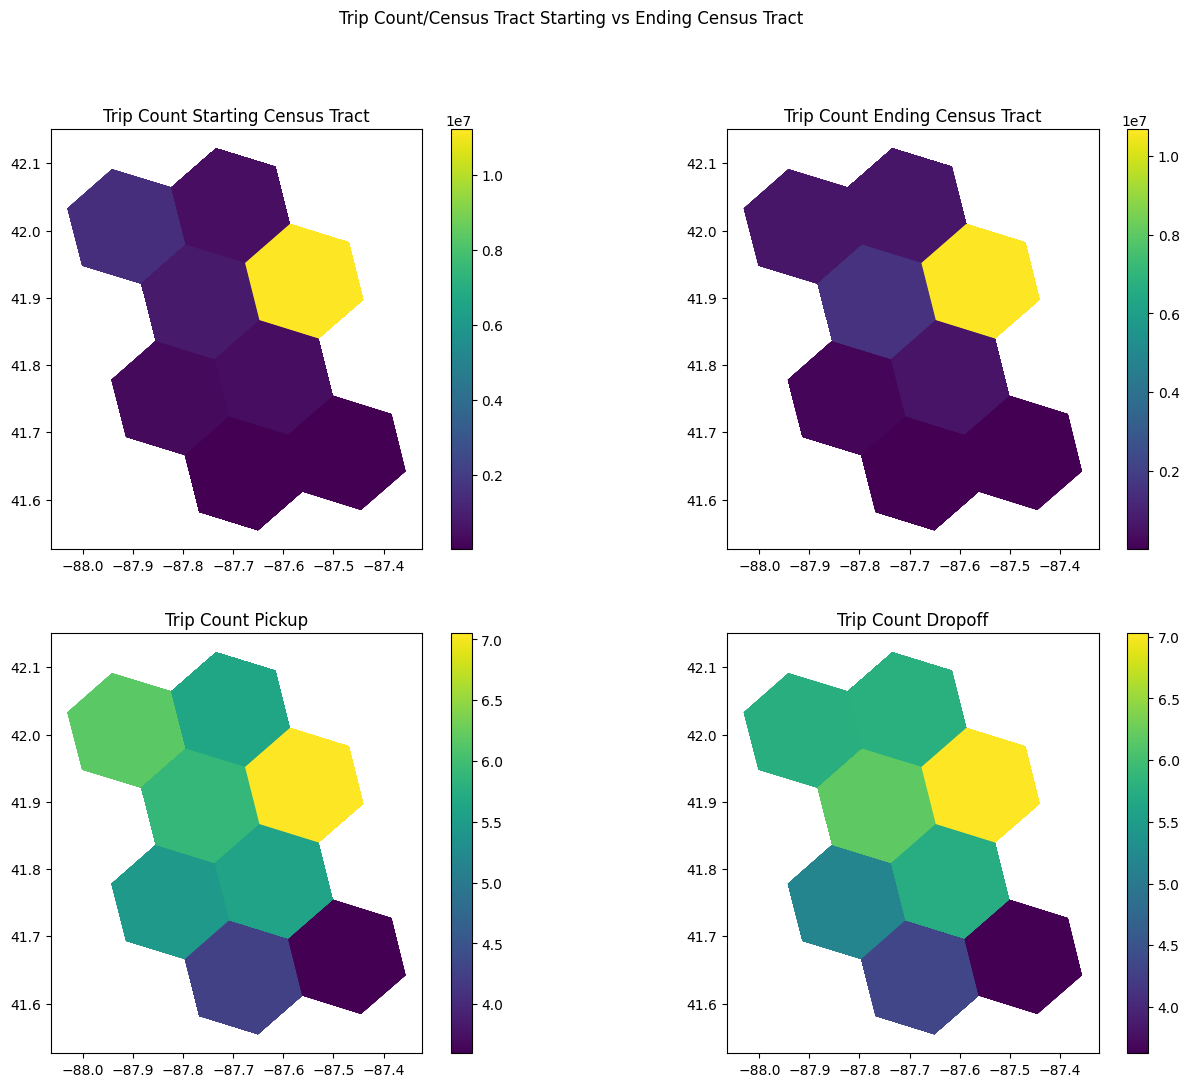

In [17]:
# plot trip count based on h3 hexagons resolution 5
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 5 Pickup vs Dropoff')
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_5'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_5', 0, 0, 'Trip Count Starting Census Tract')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_5'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_5', 0, 1, 'Trip Count Ending Census Tract')

# transform count
trip_counts_starting["pickup_count_5_log10"] = trip_counts_starting['pickup_count_5'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_5_log10"] = trip_counts_ending['dropoff_count_5'].apply(lambda x: np.log10(x) if x > 0 else 0)

plot_geodata(trip_counts_starting, ax, 'pickup_count_5_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_5_log10', 1, 1, 'Trip Count Dropoff')


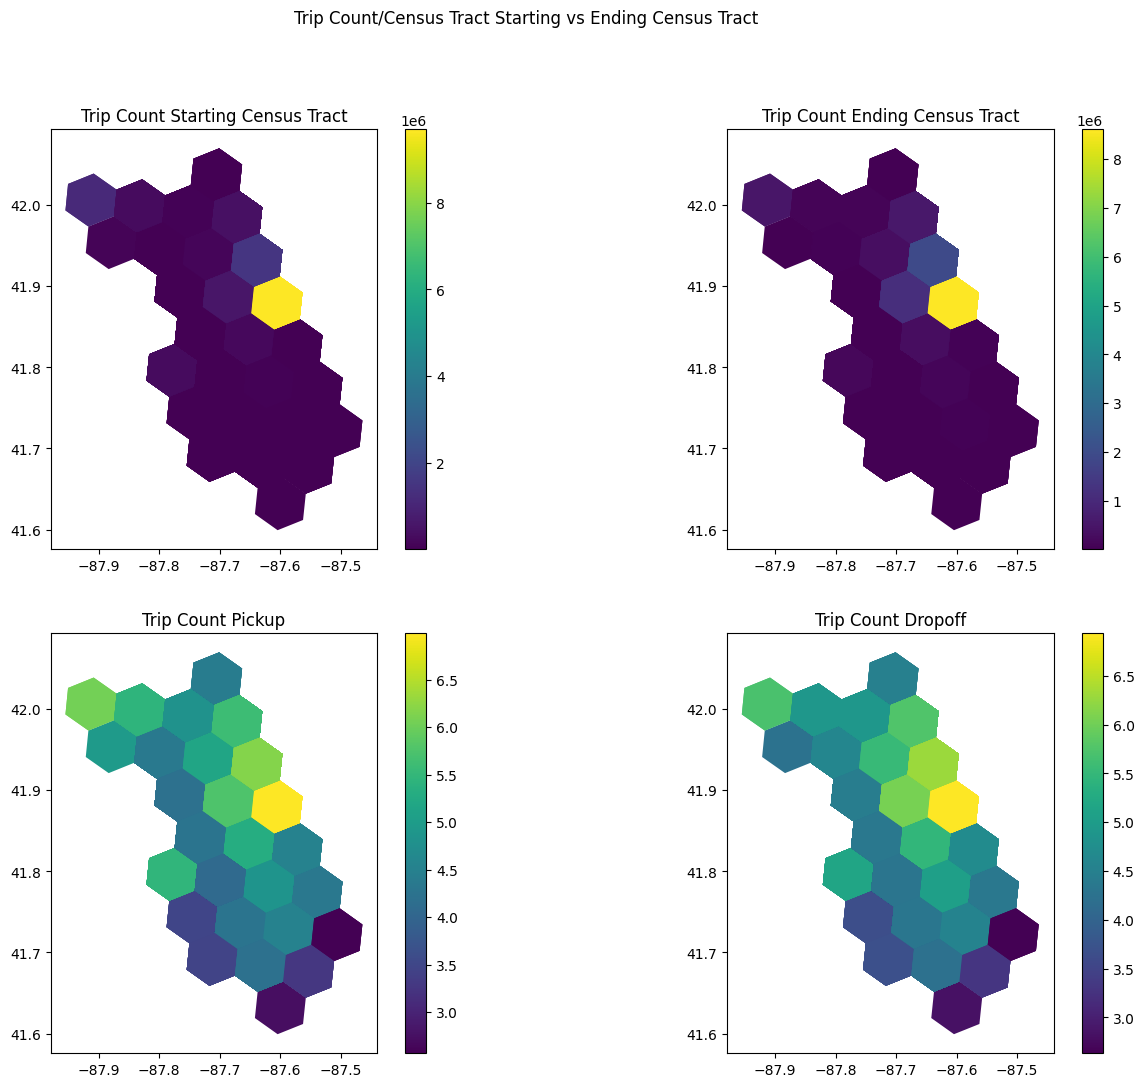

In [18]:
# plot trip count based on h3 hexagons resolution 6
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 6 Pickup vs Dropoff')

trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_6'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_6', 0, 0, 'Trip Count Starting Census Tract')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_6'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_6', 0, 1, 'Trip Count Ending Census Tract')

# Transform count
trip_counts_starting["pickup_count_6_log10"] = trip_counts_starting['pickup_count_6'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_6_log10"] = trip_counts_ending['dropoff_count_6'].apply(lambda x: np.log10(x) if x > 0 else 0)

plot_geodata(trip_counts_starting, ax, 'pickup_count_6_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_6_log10', 1, 1, 'Trip Count Dropoff')


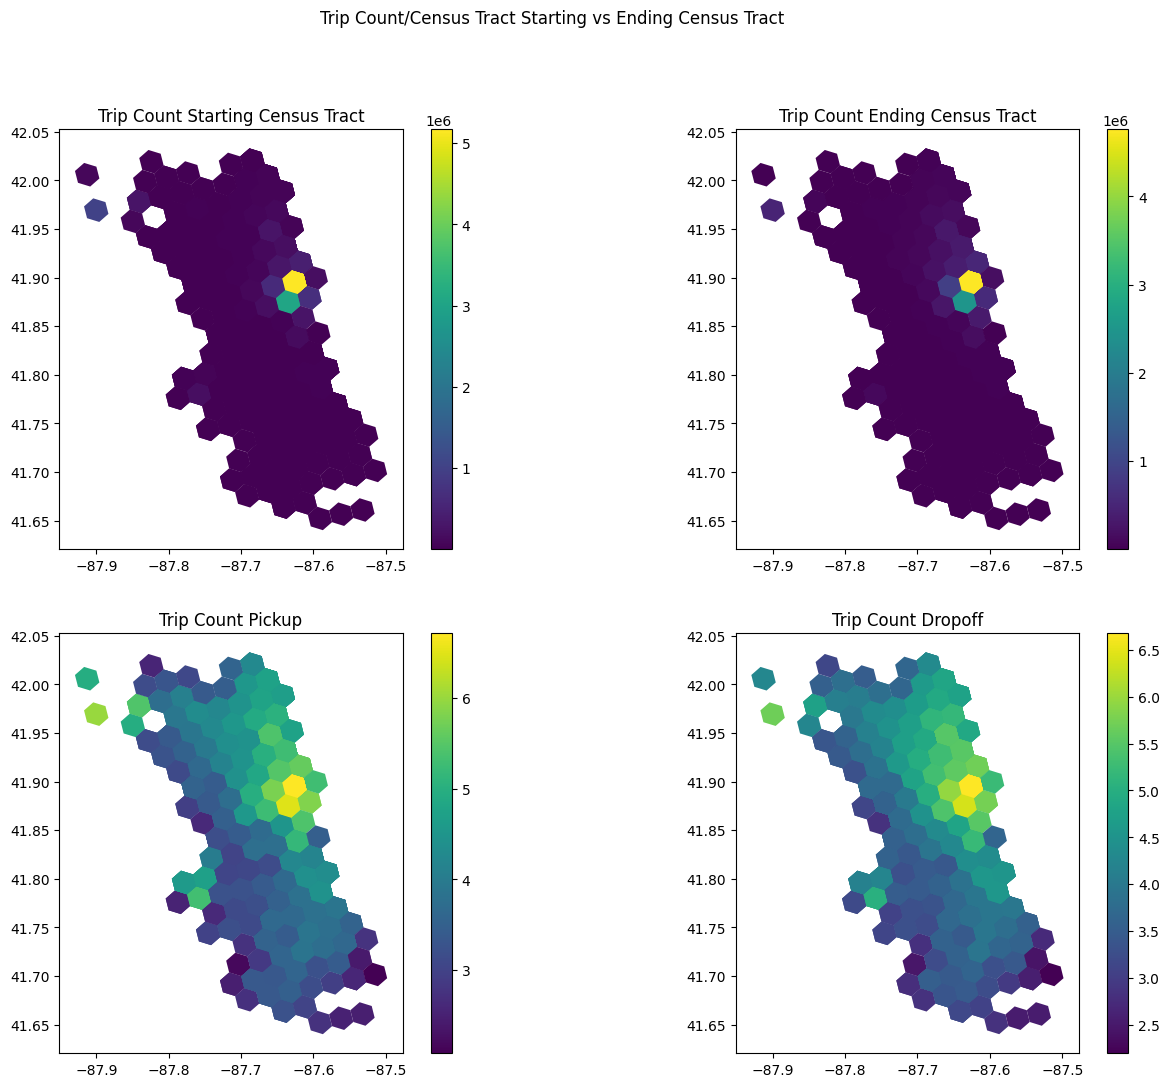

In [19]:
# plot trip count based on h3 hexagons resolution 7
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 7 Pickup vs Dropoff')
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_7'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_7', 0, 0, 'Trip Count Starting Census Tract')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_7'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_7', 0, 1, 'Trip Count Ending Census Tract')

# Transform count
trip_counts_starting["pickup_count_7_log10"] = trip_counts_starting['pickup_count_7'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_7_log10"] = trip_counts_ending['dropoff_count_7'].apply(lambda x: np.log10(x) if x > 0 else 0)

plot_geodata(trip_counts_starting, ax, 'pickup_count_7_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_7_log10', 1, 1, 'Trip Count Dropoff')

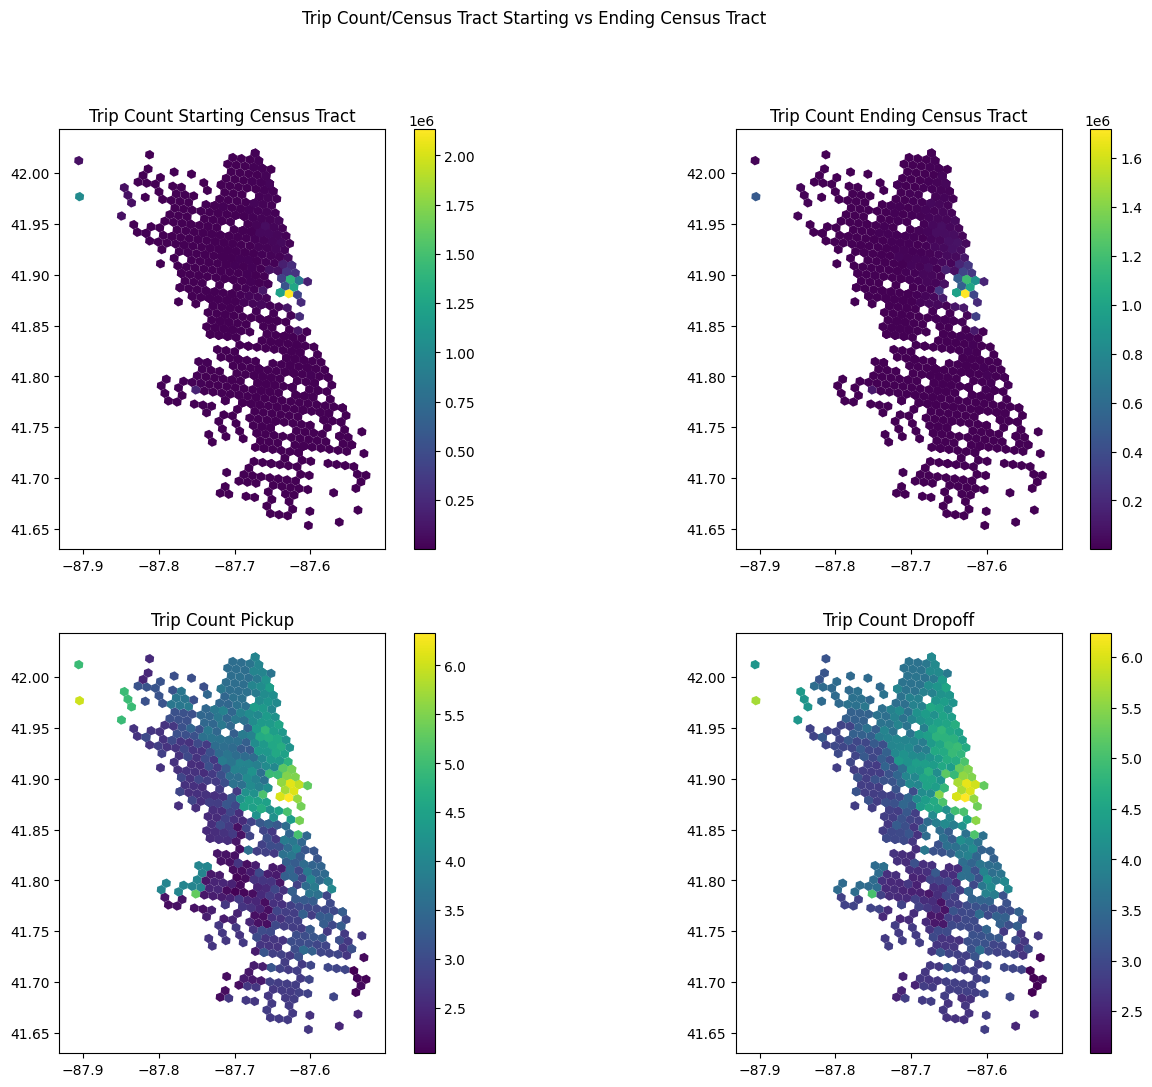

In [20]:
# plot trip count based on h3 hexagons resolution 8
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 8 Pickup vs Dropoff')
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_8'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_8', 0, 0, 'Trip Count Starting Census Tract')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_8'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_8', 0, 1, 'Trip Count Ending Census Tract')

# Transform count
trip_counts_starting["pickup_count_8_log10"] = trip_counts_starting['pickup_count_8'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_8_log10"] = trip_counts_ending['dropoff_count_8'].apply(lambda x: np.log10(x) if x > 0 else 0)

plot_geodata(trip_counts_starting, ax, 'pickup_count_8_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_8_log10', 1, 1, 'Trip Count Dropoff')

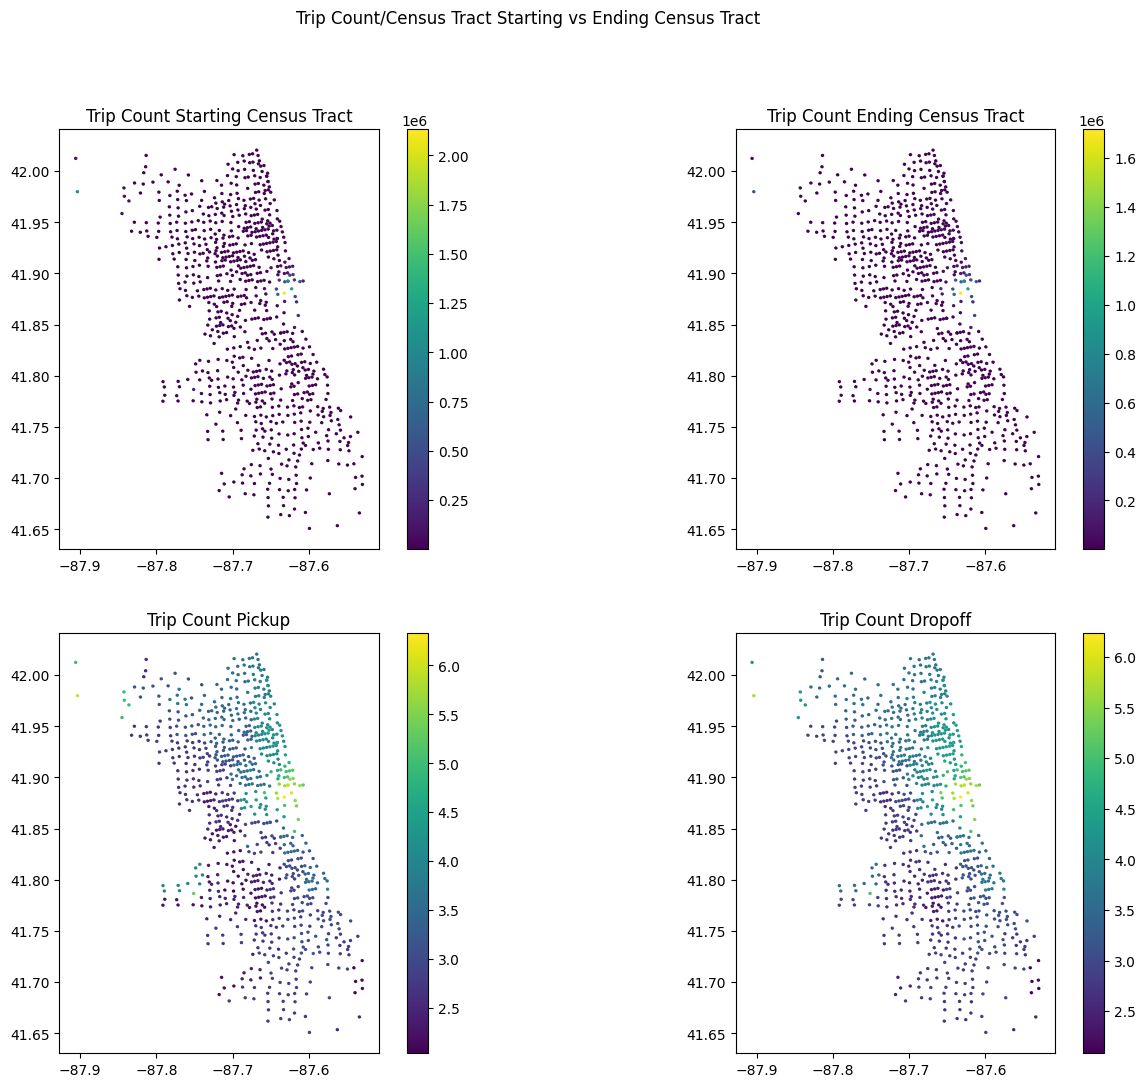

In [21]:
# plot trip count based on h3 hexagons resolution 9
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle('Trip Count per H3 Hexagons Resolution 9 Pickup vs Dropoff')
trip_counts_starting = gpd.GeoDataFrame(trip_counts_starting, geometry=trip_counts_starting['geometry_h3_9'], crs='EPSG:4326')
plot_geodata(trip_counts_starting, ax, 'pickup_count_9', 0, 0, 'Trip Count Starting Census Tract')
trip_counts_ending = gpd.GeoDataFrame(trip_counts_ending, geometry=trip_counts_ending['geometry_h3_9'], crs='EPSG:4326')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_9', 0, 1, 'Trip Count Ending Census Tract')

# Transform count
trip_counts_starting["pickup_count_9_log10"] = trip_counts_starting['pickup_count_9'].apply(lambda x: np.log10(x) if x > 0 else 0)
trip_counts_ending["dropoff_count_9_log10"] = trip_counts_ending['dropoff_count_9'].apply(lambda x: np.log10(x) if x > 0 else 0)

plot_geodata(trip_counts_starting, ax, 'pickup_count_9_log10', 1, 0, 'Trip Count Pickup')
plot_geodata(trip_counts_ending, ax, 'dropoff_count_9_log10', 1, 1, 'Trip Count Dropoff')

A resolution of 7 seems to be most appropriate for further use as it is detailed enough to differentiate different areas but not too fine-grained to leave gaps in the data. 

In this case, the hexagons point to the same areas, not yielding much more information than on census tract level, but they might be useful for other parts of the analysis, such as clustering.

In [22]:
# get rid of other hexagon resoultion data
boundaries = boundaries.loc[:, ['census', 'geometry', 'centroid', 'h3_7', 'geometry_h3_7', 'centroid_h3_7']]

## Idle Time Analysis

The time between trips can be an indicator for demand. Low idle time are ideal, meaning that taxis don't have to wait long for the next customer, while a higher idle time means that the vehicles are underutilized. In this case, the client might want to re-direct them to more popular areas to ensure that the demand can be meet there and to not lose out on potential customers. 

In [23]:
# set index to combination of initial index and taxi ID to facilitate the computation of the idle time between two trips for a taxi
taxi_trips_df= taxi_trips_df.sort_values(by=['trip_start', 'trip_end'])
taxi_trips_df.reset_index(drop=True, inplace=True)
taxi_trips_df.set_index(['taxi_id', taxi_trips_df.index], inplace=True)
taxi_trips_df.sort_index(inplace=True)

In [24]:
# compute idle time between trips
idle_times = pd.Series()
for id in taxi_trips_df.index.get_level_values(0).unique():
    current_taxi = taxi_trips_df.loc[id]
    current_taxi = current_taxi.assign(idle_time = lambda x: x['trip_start'] - x['trip_end'].shift(1))
    idle_time_taxi = current_taxi['idle_time']
    idle_times =  pd.concat([idle_times, idle_time_taxi])

# ensure idle time is in datetime seconds
idle_times = idle_times.dt.total_seconds()
taxi_trips_df.set_index([taxi_trips_df.index.get_level_values(1)], inplace=True)
    
# make idle time new feature for each trip 
taxi_trips_df['idle_seconds'] = idle_times


/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_27212/1091486050.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  idle_times =  pd.concat([idle_times, idle_time_taxi])


In [25]:
# check for negative values as this should not be the case
print(len(taxi_trips_df[taxi_trips_df['idle_seconds'] < 0 ]))
taxi_trips_df[taxi_trips_df['idle_seconds'] < 0]
# drop negative value trips
taxi_trips_df = taxi_trips_df[taxi_trips_df['idle_seconds'] >= 0]

31287


### Idle Time on Census Tract Level

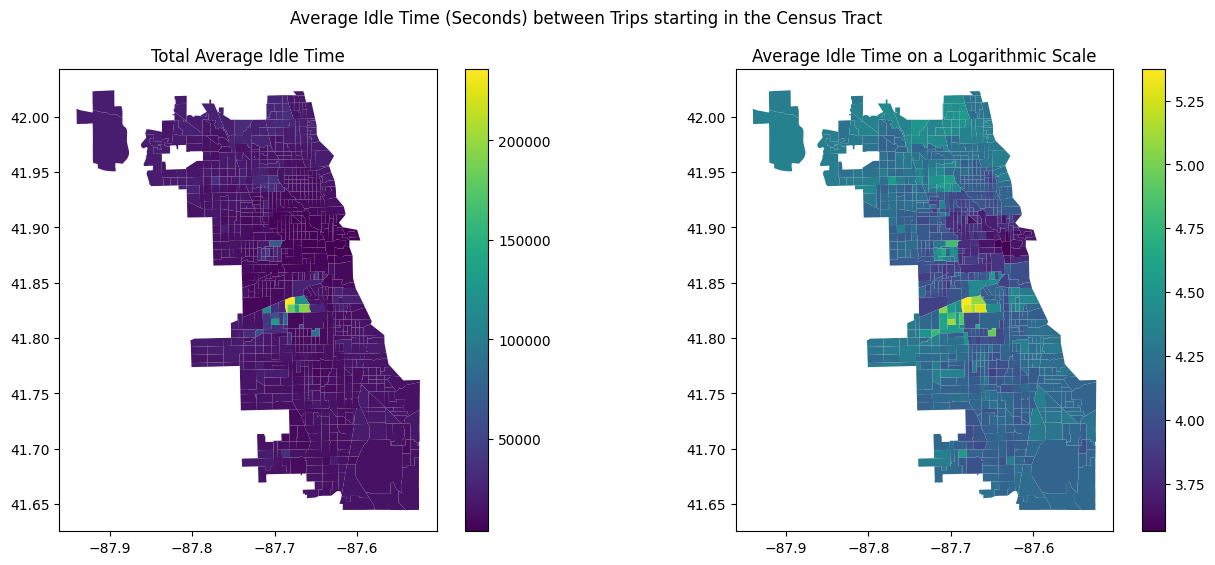

In [27]:
# calculate average idle time per pickup census tract
average_idle_time_per_tract = taxi_trips_df.groupby('pickup_census')['idle_seconds'].mean().reset_index()
average_idle_time_per_tract = pd.merge(boundaries, average_idle_time_per_tract, left_on="census", right_on='pickup_census', how='left')
average_idle_time_per_tract = gpd.GeoDataFrame(average_idle_time_per_tract, geometry="geometry")

# rename the column for clarity
average_idle_time_per_tract.rename(columns={'idle_seconds': 'average_idle_time'}, inplace=True)

# apply logarithmic transformation 
average_idle_time_per_tract["average_idle_time_log10"] = average_idle_time_per_tract['average_idle_time'].apply(lambda x: np.log10(x) if x > 0 else 0)

# plot the average idle time per census tract, total and on logarithmic scale
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Idle Time (Seconds) between Trips starting in the Census Tract')

plot_geodata(average_idle_time_per_tract, ax, 'average_idle_time', 0,0, "Total Average Idle Time (Seconds)")
plot_geodata(average_idle_time_per_tract, ax, 'average_idle_time_log10', 0,1, "Average Idle Time (Seconds) on a Logarithmic Scale")

As expected, the idle time in the city centre is the lowest. An interesting area is the one below the south-west of the city centre as it has a very high average idle time. Vehicles from there should be transferred to higher demand areas.

In [28]:
# calculate max, mean, and min idle time (in seconds) on a census tract level
print(f"maximum average idle time for a census tract: {average_idle_time_per_tract['average_idle_time'].max()}\nmean average idle time for a census tract: {average_idle_time_per_tract['average_idle_time'].mean()}\nminimum average idle time for a census tract: {average_idle_time_per_tract['average_idle_time'].min()}")

maximum average idle time for a census tract: 235657.33015494636
mean average idle time for a census tract: 16498.077587890733
minimum average idle time for a census tract: 3663.9187552224657


### Idle Time H3 Hexagons (Resolution 7)

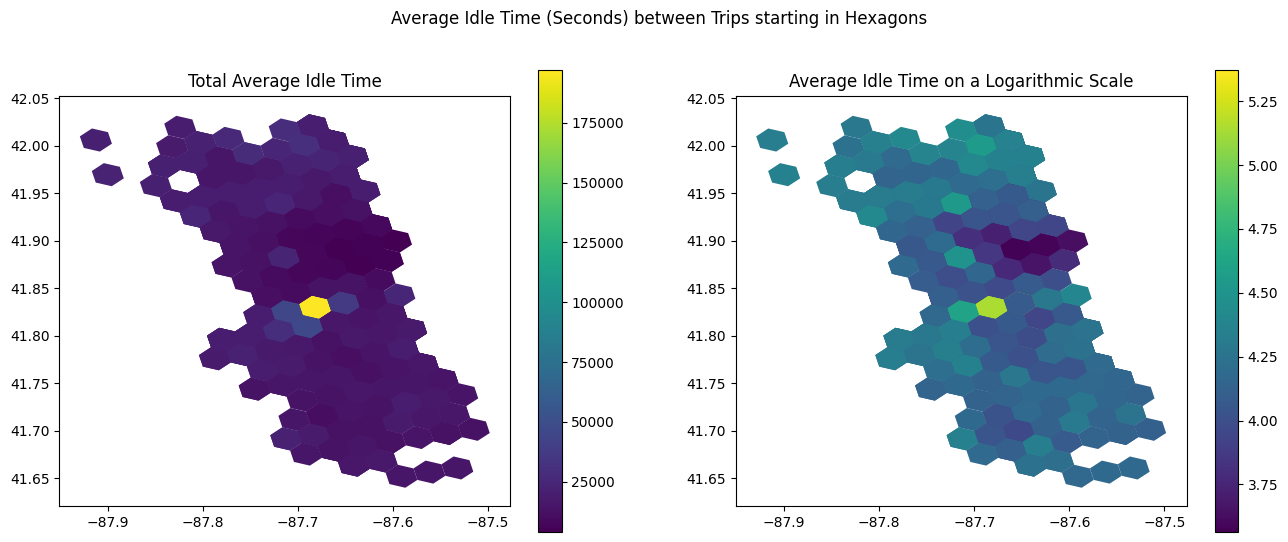

In [29]:
average_idle_time_per_hexagon = pd.merge(taxi_trips_df, boundaries, left_on="pickup_census", right_on='census', how='left')

# calculate average idle time per pickup hexagon
average_idle_time_per_hexagon = average_idle_time_per_hexagon.groupby('h3_7')['idle_seconds'].mean().reset_index()
average_idle_time_per_hexagon = pd.merge(boundaries, average_idle_time_per_hexagon, on="h3_7", how='left')
average_idle_time_per_hexagon = gpd.GeoDataFrame(average_idle_time_per_hexagon, geometry="geometry_h3_7")

# rename the column for clarity
average_idle_time_per_hexagon.rename(columns={'idle_seconds': 'average_idle_time'}, inplace=True)

# apply logarithmic transformation transformation 
average_idle_time_per_hexagon["average_idle_time_log10"] = average_idle_time_per_tract['average_idle_time'].apply(lambda x: np.log10(x) if x > 0 else 0)

# plot the average idle time per hexagon, total and on logarithmic scale
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Idle Time (Seconds) between Trips starting in Hexagons')

plot_geodata(average_idle_time_per_hexagon, ax, 'average_idle_time', 0,0, "Total Average Idle Time")
plot_geodata(average_idle_time_per_hexagon, ax, 'average_idle_time_log10', 0,1, "Average Idle Time on a Logarithmic Scale")

## Trip Length Analysis 

By looking at the average trip length, differentiating between pickup and dropof, we can see if they come from far away to reach their destination or respectively if the census tract is a starting point for long or short trips.

We assume that the values for trip length, fare, and duration are correlated. We check this first so we do not spend unnecessary efforts into plotting them all and isntead just use one as stand-in for the others. 

                  fare  trip_seconds  trip_miles
fare          1.000000      0.867327    0.890005
trip_seconds  0.867327      1.000000    0.745020
trip_miles    0.890005      0.745020    1.000000


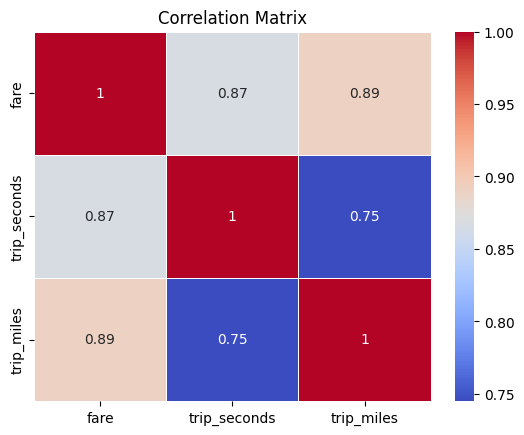

In [30]:
correlation_matrix = taxi_trips_df[['fare', 'trip_seconds', 'trip_miles']].corr()

# Display correlation matrix
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We see that the variables are correlated, especially the trip_miles and the fare. In the following, the trip length (in miles) is used as stand-in for the other variables. 

### Trip Length on Census Tract Level

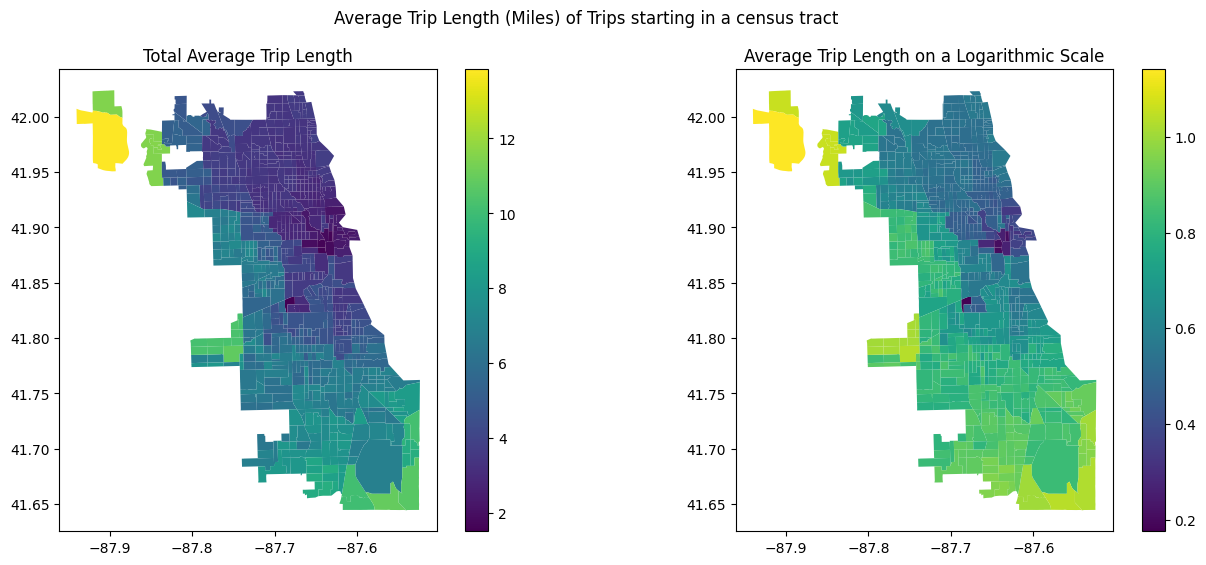

In [31]:
# calculate average trip length per pickup census tract
average_trip_length_per_tract = taxi_trips_df.groupby('pickup_census')['trip_miles'].mean().reset_index()
average_trip_length_per_tract = pd.merge(boundaries, average_trip_length_per_tract, left_on="census", right_on='pickup_census', how='left')
average_trip_length_per_tract = gpd.GeoDataFrame(average_trip_length_per_tract, geometry="geometry")

# rename the column for clarity
average_trip_length_per_tract.rename(columns={'trip_miles': 'average_trip_length'}, inplace=True)

# apply logarithmic transformation 
average_trip_length_per_tract["average_trip_length_log10"] = average_trip_length_per_tract['average_trip_length'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Length (Miles) of Trips starting in a census tract')

plot_geodata(average_trip_length_per_tract, ax, 'average_trip_length', 0,0, "Total Average Trip Length (Miles)")
plot_geodata(average_trip_length_per_tract, ax, 'average_trip_length_log10', 0,1, "Average Trip Length (Miles) on a Logarithmic Scale")


In [32]:
# Calculate max, mean, and min trip length (in miles) on a census tract level
print(f"maximum average trip length in miles for a census tract: {average_trip_length_per_tract['average_trip_length'].max()}\naverage trip length in miles for all census tracts: {average_trip_length_per_tract['average_trip_length'].mean()}\nminimum average trip length in miles for a census tract: {average_trip_length_per_tract['average_trip_length'].min()}")

maximum average trip length in miles for a census tract: 13.850807323299353
average trip length in miles for all census tracts: 5.068357483537116
minimum average trip length in miles for a census tract: 1.497967818831943


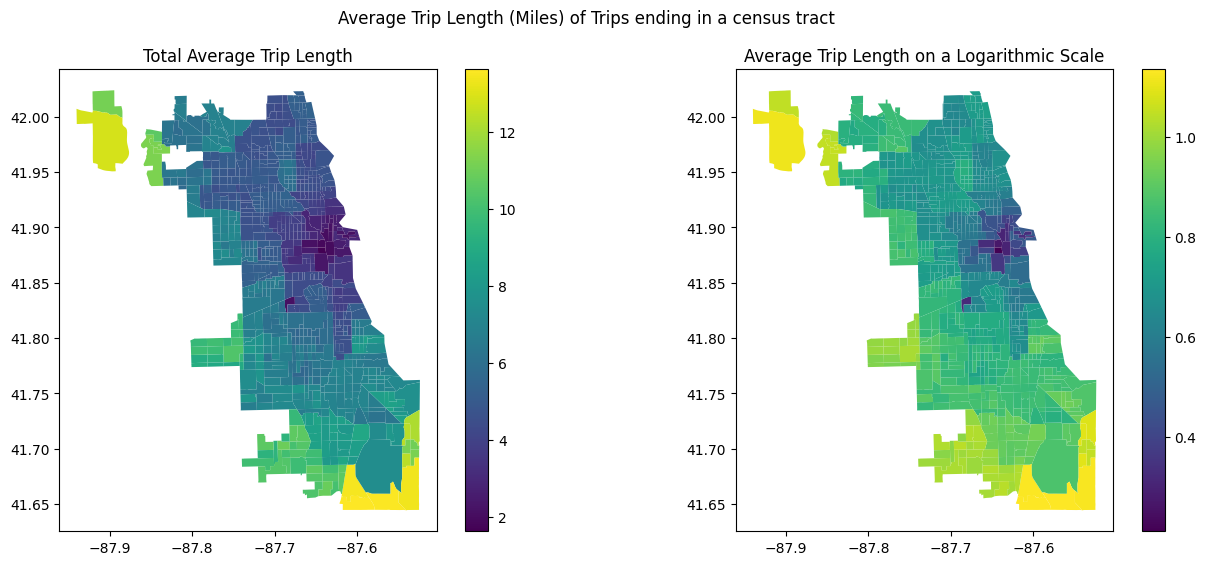

In [33]:
# calculate average trip length per dropoff census tract
average_trip_length_per_tract = taxi_trips_df.groupby('dropoff_census')['trip_miles'].mean().reset_index()
average_trip_length_per_tract = pd.merge(boundaries, average_trip_length_per_tract, left_on="census", right_on='dropoff_census', how='left')
average_trip_length_per_tract = gpd.GeoDataFrame(average_trip_length_per_tract, geometry="geometry")

# rename the column for clarity
average_trip_length_per_tract.rename(columns={'trip_miles': 'average_trip_length'}, inplace=True)

# apply logarithmic transformation 
average_trip_length_per_tract["average_trip_length_log10"] = average_trip_length_per_tract['average_trip_length'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Length (Miles) of Trips ending in a census tract')

plot_geodata(average_trip_length_per_tract, ax, 'average_trip_length', 0,0, "Total Average Trip Length")
plot_geodata(average_trip_length_per_tract, ax, 'average_trip_length_log10', 0,1, "Average Trip Length on a Logarithmic Scale")

This visualization of the average trip length indicates that customers in the outer city areas, including the airport, take longer trips (assumption: to the city centre and come from the centre to reach their destination), but also that there are many shorter rides within the city centre (possible visitors or business people). 

### Trip Length using Hexagons (Resolution 7)

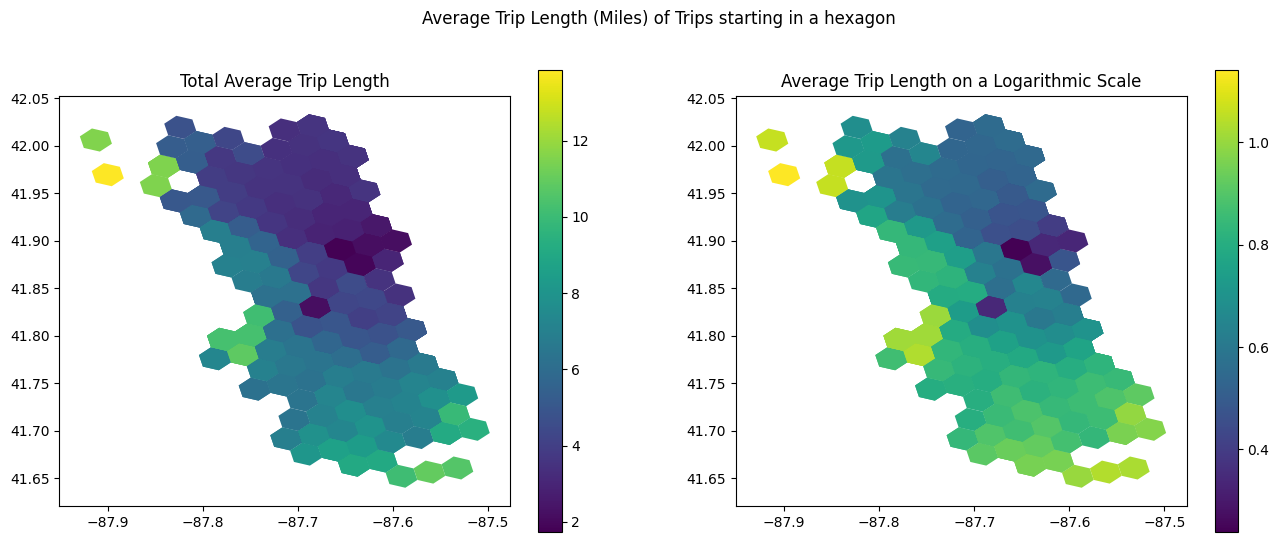

In [34]:
average_trip_length_per_hexagon = pd.merge(taxi_trips_df, boundaries, left_on="pickup_census", right_on='census', how='left')

# calculate average trip length per hexagon
average_trip_length_per_hexagon = average_trip_length_per_hexagon.groupby('h3_7')['trip_miles'].mean().reset_index()
average_trip_length_per_hexagon = pd.merge(boundaries, average_trip_length_per_hexagon, on='h3_7', how='left')
average_trip_length_per_hexagon = gpd.GeoDataFrame(average_trip_length_per_hexagon, geometry="geometry_h3_7")

# rename the column for clarity
average_trip_length_per_hexagon.rename(columns={'trip_miles': 'average_trip_length'}, inplace=True)

# apply logarithmic transformation 
average_trip_length_per_hexagon["average_trip_length_log10"] = average_trip_length_per_hexagon['average_trip_length'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Length (Miles) of Trips starting in a hexagon')

plot_geodata(average_trip_length_per_hexagon, ax, 'average_trip_length', 0,0, "Total Average Trip Length")
plot_geodata(average_trip_length_per_hexagon, ax, 'average_trip_length_log10', 0,1, "Average Trip Length on a Logarithmic Scale")


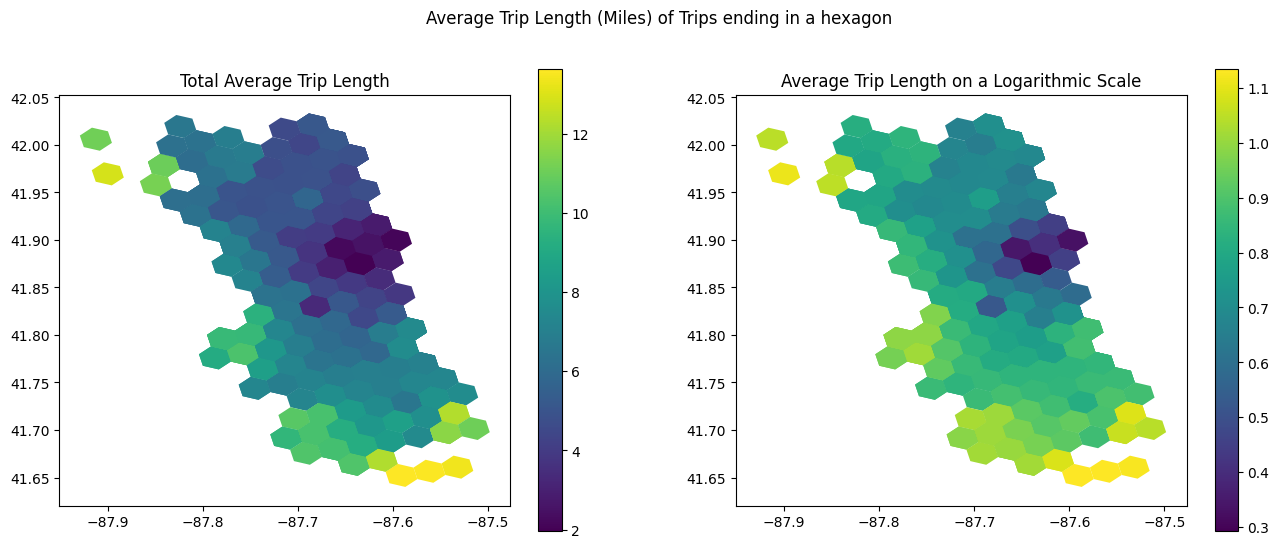

In [135]:
average_trip_length_per_hexagon = pd.merge(taxi_trips_df, boundaries, left_on="dropoff_census", right_on='census', how='left')

# calculate average trip length per hexagon
average_trip_length_per_hexagon = average_trip_length_per_hexagon.groupby('h3_7')['trip_miles'].mean().reset_index()
average_trip_length_per_hexagon = pd.merge(boundaries, average_trip_length_per_hexagon, on='h3_7', how='left')
average_trip_length_per_hexagon = gpd.GeoDataFrame(average_trip_length_per_hexagon, geometry="geometry_h3_7")

# rename the column for clarity
average_trip_length_per_hexagon.rename(columns={'trip_miles': 'average_trip_length'}, inplace=True)

# apply logarithmic transformation 
average_trip_length_per_hexagon["average_trip_length_log10"] = average_trip_length_per_hexagon['average_trip_length'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Length (Miles) of Trips ending in a hexagon')

plot_geodata(average_trip_length_per_hexagon, ax, 'average_trip_length', 0,0, "Total Average Trip Length")
plot_geodata(average_trip_length_per_hexagon, ax, 'average_trip_length_log10', 0,1, "Average Trip Length on a Logarithmic Scale")

## Point-of-Interest & Landuse

Chicago has many point-of-interest that might influence demand. Furthermore, looking at the landuse within the city might give insights into the demand pattern we discovered so far.

In [35]:
# import spatial features
census_spatial_features = gpd.read_file(f'{file_path}census_spatial_features.geojson')

In [36]:
census_spatial_features = pd.merge(boundaries,census_spatial_features, left_on="census", right_on='census', how='left')

# convert merged DataFrame to a geodataframe
census_spatial_features = gpd.GeoDataFrame(census_spatial_features, geometry='geometry_x')

### Point-of-Interest Data

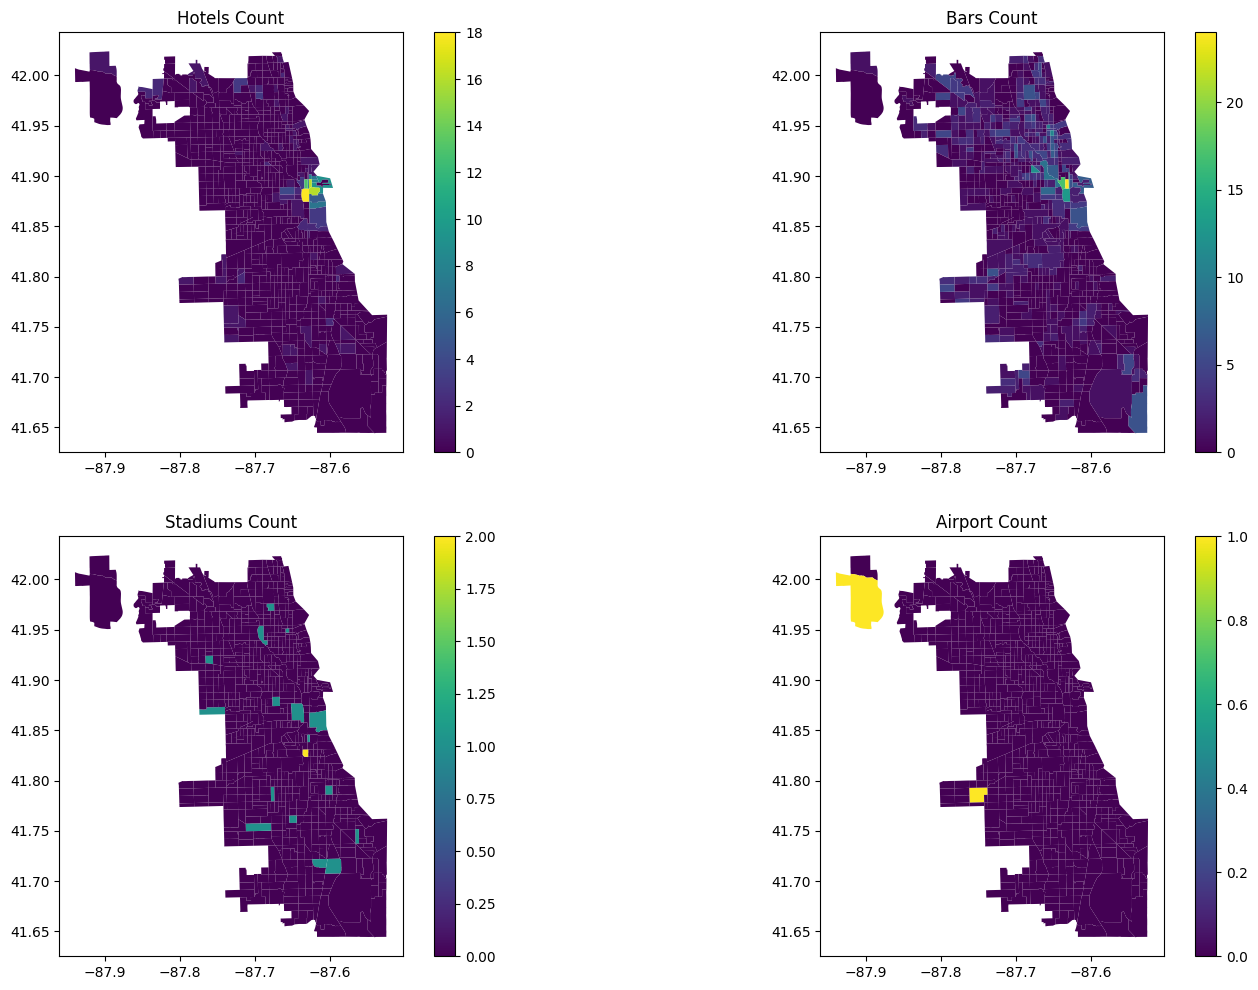

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# plot data for hotels
plot_geodata(census_spatial_features, ax,  'num_hotels', 0,0,'Hotels Count')

# plot data for bars
plot_geodata(census_spatial_features, ax,  'num_bars', 0,1,'Bars Count')

# plot data for stadiums
plot_geodata(census_spatial_features, ax, 'num_stadiums', 1,0, 'Stadiums Count')

# plot data for airports
plot_geodata(census_spatial_features, ax, 'airport_in_census', 1,1, 'Airport Count')

The information on the point of interest just enforce what we already assumed: With hotels and bars concentrated on the city centre, potential customer groups are people on a night out or visitors of the city. The latter is reinforced by the airports being important pickup and dropoff locations. 

### Landuse Data

Another view on this could be provided by landuse data, meaning how the different areas are mainly used, e.g. residential areas and such.

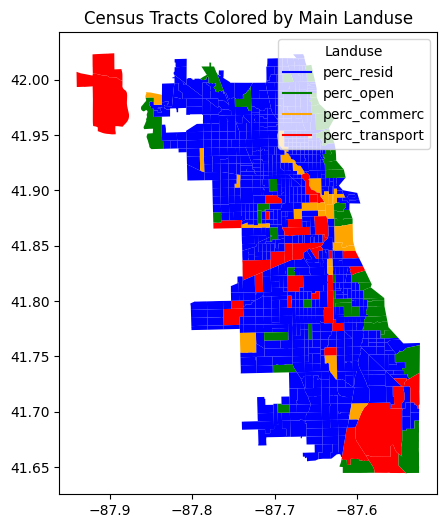

In [38]:
color_mapping = {
    'perc_resid': 'blue',
    'perc_open': 'green',
    'perc_commerc': 'orange',
    'perc_transport': 'red'
}

# determine the max category for each row and map it to the corresponding color
census_spatial_features['color'] = census_spatial_features[
    ['perc_resid', 'perc_open', 'perc_commerc', 'perc_transport']
].idxmax(axis=1).map(color_mapping)

# plot the map
fig, ax = plt.subplots(figsize=(12, 6))
census_spatial_features.plot(color=census_spatial_features['color'], ax=ax)

# create a custom legend
handles = [plt.Line2D([0], [0], color=color, label=label) 
           for label, color in color_mapping.items()]
ax.legend(handles=handles, title="Landuse")

plt.title("Census Tracts Colored by Main Landuse")
plt.show()

Unsupringly, the city centre as demand hotspot is a commercial area while the residential areas are not. This might suggest however, that mainly visitors not home to the city use ride-hailing services.

# 2. Temporal Analysis

By looking at different temporal resolutions, we hope to discover patterns related to time, like whether demand and other features differentiate depending on the time of day or the weekday. This again helps to better understand customers and tailor the client's operation of their ride-hailing platform to the customer's needs. 

In [39]:
# split the start timestamp data into day / month / hour / day of week / week of year
taxi_trips_df["start_hour"] = taxi_trips_df["trip_start"].apply(lambda x: x.hour)
taxi_trips_df["start_day_of_month"] = taxi_trips_df["trip_start"].apply(lambda x: x.day)
taxi_trips_df["start_month"] = taxi_trips_df["trip_start"].apply(lambda x: x.month)
taxi_trips_df["start_weekday"] = taxi_trips_df["trip_start"].apply(lambda x: x.dayofweek)

taxi_trips_df["end_hour"] = taxi_trips_df["trip_end"].apply(lambda x: x.hour)
taxi_trips_df["end_day_of_month"] = taxi_trips_df["trip_end"].apply(lambda x: x.day)
taxi_trips_df["end_month"] = taxi_trips_df["trip_end"].apply(lambda x: x.month)
taxi_trips_df["end_weekday"] = taxi_trips_df["trip_end"].apply(lambda x: x.dayofweek)

taxi_trips_df['start_week'] = taxi_trips_df['trip_start'].dt.isocalendar().week
taxi_trips_df['end_week'] = taxi_trips_df['trip_end'].dt.isocalendar().week

In [40]:
# calculate different temporal discretization (e.g., hourly, 4-hourly, daily) - hourly & daily already exists; bin start & end data into 2/4/6-hour intervals
intervals = {
    '2_hour': {'bins': [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], 'labels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
    '4_hour': {'bins': [0, 3, 7, 11, 15, 19, 23], 'labels': [1, 2, 3, 4, 5, 6]},
    '6_hour': {'bins': [0, 5, 11, 17, 23], 'labels': [1, 2, 3, 4]},
}

# iterate over the dictionary and create new columns for both start and end intervals
for key, value in intervals.items():
    # create the start interval columns
    start_column_name = f"start_time_{key}_interval"
    taxi_trips_df[start_column_name] = pd.cut(
        taxi_trips_df['start_hour'], 
        bins=value['bins'], 
        labels=value['labels'], 
        include_lowest=True
    )
    
    # create the end interval columns
    end_column_name = f"end_time_{key}_interval"
    taxi_trips_df[end_column_name] = pd.cut(
        taxi_trips_df['end_hour'], 
        bins=value['bins'], 
        labels=value['labels'], 
        include_lowest=True
    )

In [41]:
# import weather data 
weather_df = pd.read_csv(f"{file_path}weather_chicago_2019.csv")
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

# extract date and hour into separate columns
weather_df['date'] = weather_df['datetime'].dt.date
weather_df['hour'] = weather_df['datetime'].dt.hour

# drop the original 'timestamp' column 
weather_df = weather_df.drop(columns=['datetime'])

In [42]:
# ensure 'start_day' and 'date' are datetime.date 
taxi_trips_df['start_day'] = pd.to_datetime(taxi_trips_df['start_day']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

# ensure 'start_hour' and 'hour' are integers
taxi_trips_df['start_hour'] = taxi_trips_df['start_hour'].astype(int)
weather_df['hour'] = weather_df['hour'].astype(int)

# merge weather data to trips
taxi_trips_df = pd.merge(
    taxi_trips_df,
    weather_df[['date', 'hour', 'temp', 'precip']],
    left_on=['start_day', 'start_hour'],
    right_on=['date', 'hour'],
    how='left'  
)

## Year-Around Analysis

As a start, we are going to look at different features and how they were distributed during the whole timeframe we are investigating (in terms of frequency, e.g. how often certain values appeared). 

In [43]:
# aggregate important features by count
aggregated_df = taxi_trips_df.groupby('start_day').agg(
    count_of_rows=('start_day', 'size'),
    mean_trip_miles=('trip_miles', 'mean'),
    mean_trip_fare=('fare', 'mean'),
    mean_trip_seconds=('trip_seconds', 'mean'),
    mean_temp = ('temp', 'mean'),
    mean_precip = ('precip', 'mean')
).reset_index()

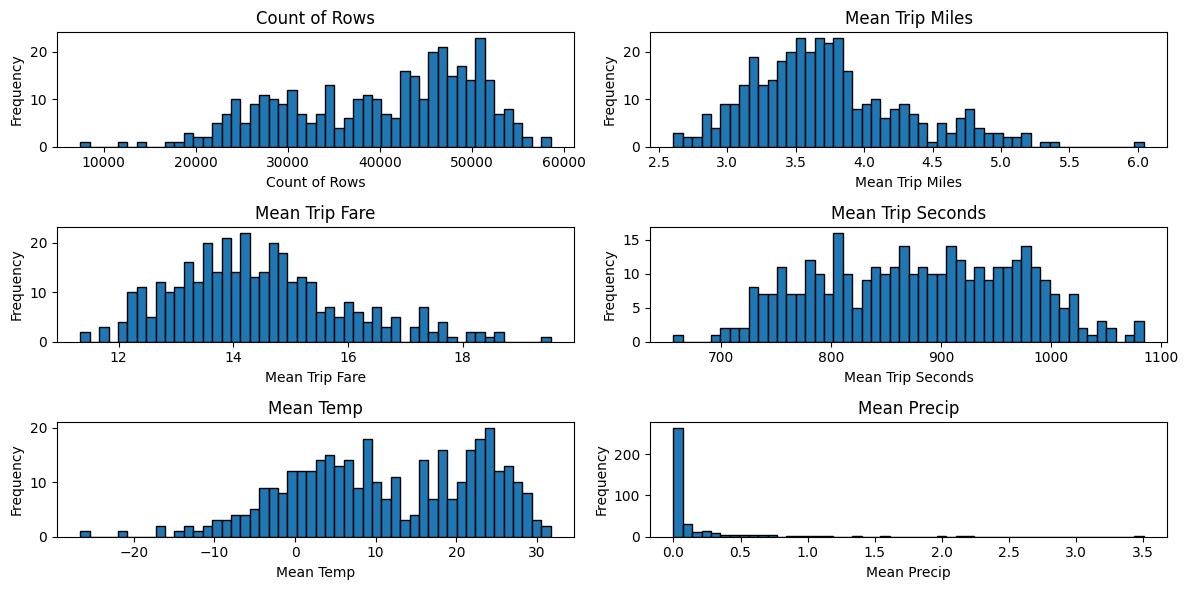

In [44]:
# list of columns, titles, and colors for the histograms
columns = ['count_of_rows', 'mean_trip_miles', 'mean_trip_fare', 
           'mean_trip_seconds', 'mean_temp', 'mean_precip']
titles = ['Count of Rows', 'Mean Trip Miles', 'Mean Trip Fare', 
          'Mean Trip Seconds', 'Mean Temp', 'Mean Precip']

fig, axs = plt.subplots(3, 2, figsize=(12, 6), tight_layout=True)

# loop over the axes, columns, titles, and colors
for ax, col, title in zip(axs.ravel(), columns, titles):
    ax.hist(aggregated_df[col], bins=50, edgecolor='black')
    ax.set_title(f'{title}')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')

# show plot
plt.show()

The following can be derived from these histograms: 
- There are days with less than 10 000 rides per day, and some days with almost 60 000 rides. 
- On most days, the rides are between 3 or 4 miles.
- The miles correlate with the fare, but not necessarily with the duration of trips as they are differently distributed.
- Chicago has more dry than wet days and tends to be either cold (less than 10) or warm (more than 20 degrees).

In [45]:
# get day with most/least counts
max_count_day = aggregated_df.loc[aggregated_df['count_of_rows'].idxmax()]
min_count_day = aggregated_df.loc[aggregated_df['count_of_rows'].idxmin()]

# extract day for these days
day_with_max_count = max_count_day['start_day']
day_with_min_count = min_count_day['start_day']

# get maximum, mean, minimum counts across all days
max_count = aggregated_df['count_of_rows'].max()
min_count = aggregated_df['count_of_rows'].min()
mean_count = aggregated_df['count_of_rows'].mean()

print(f"Day with the most counts: {day_with_max_count}")
print(f"Day with the least counts: {day_with_min_count}")
print(f"Maximum count across all days: {max_count}")
print(f"Minimum count across all days: {min_count}")
print(f"Mean count across all days: {mean_count}")


Day with the most counts: 2019-03-15
Day with the least counts: 2019-12-25
Maximum count across all days: 58526
Minimum count across all days: 7456
Mean count across all days: 39972.58082191781


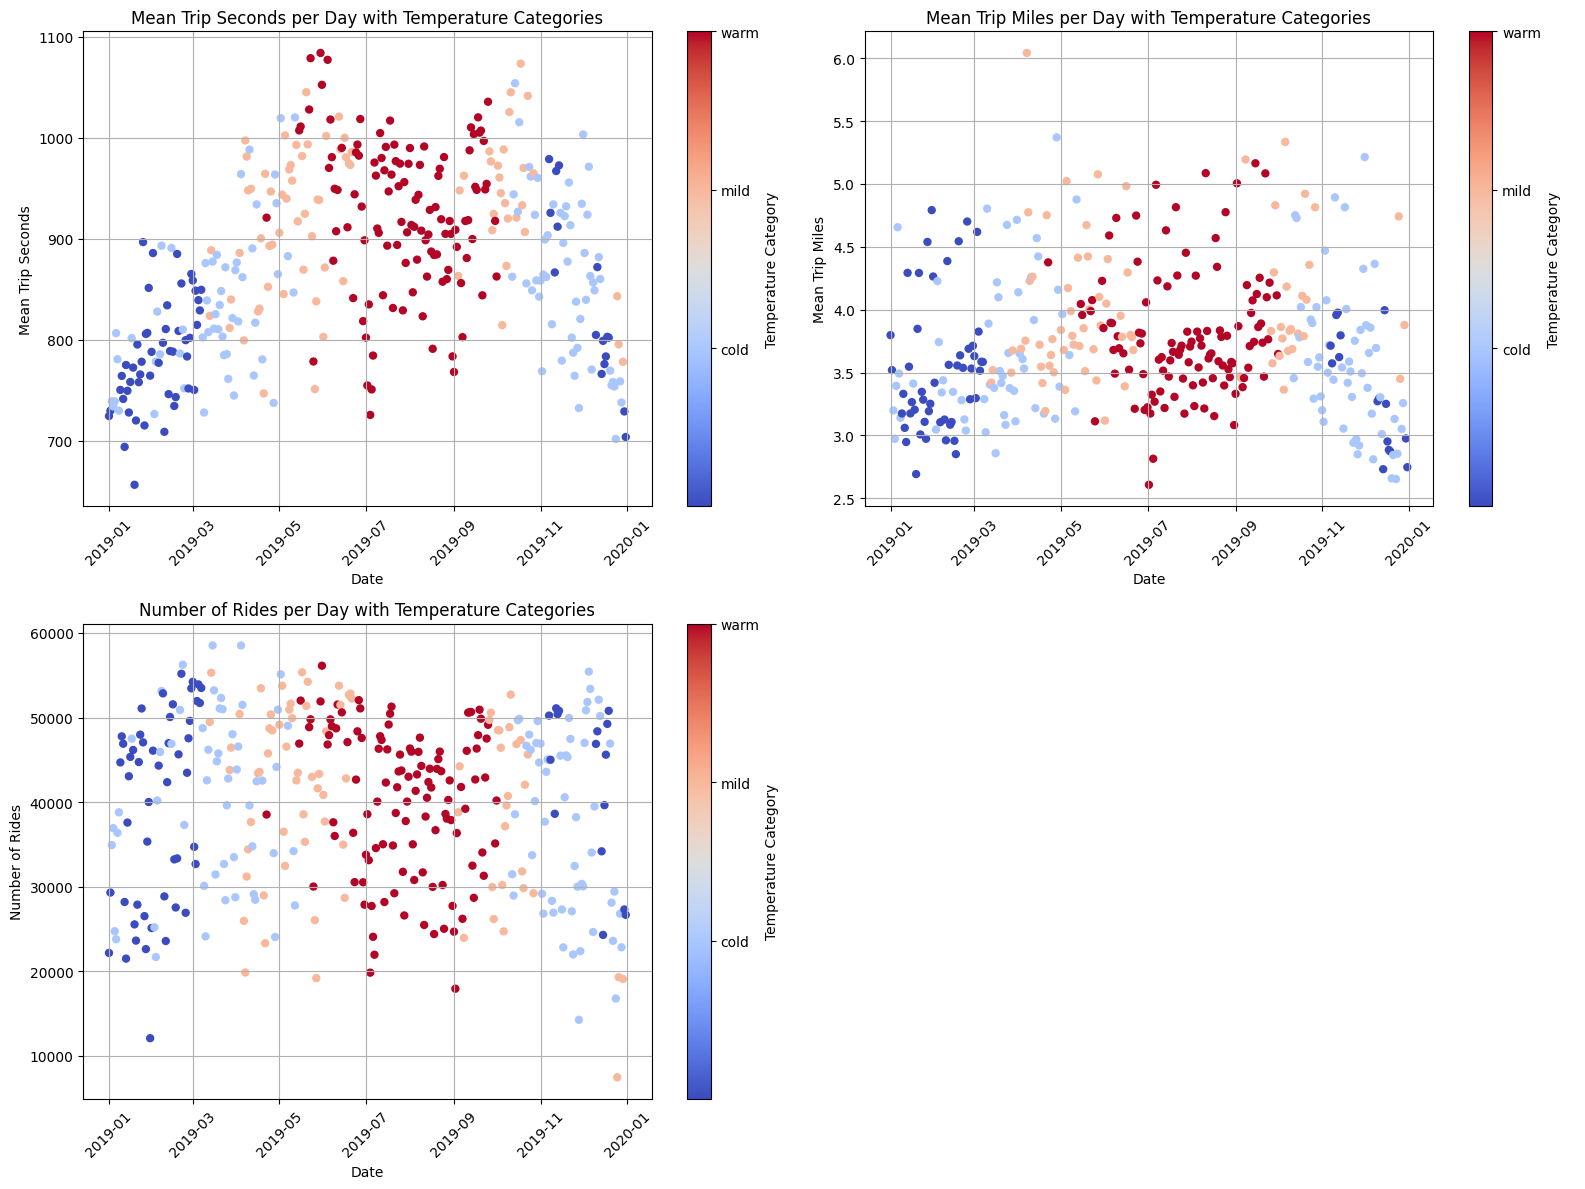

In [46]:
# define temperature bins and labels
bins = [0, 10, 20, np.inf]  # Define temperature bins
labels = ['cold', 'mild', 'warm']  # Labels for the bins
aggregated_df['temp_category'] = pd.cut(aggregated_df['mean_temp'], bins=bins, labels=labels)

# define plot parameters
plot_params = [
    ('mean_trip_seconds', 'Mean Trip Seconds', 'Mean Trip Seconds per Day with Temperature Categories'),
    ('mean_trip_miles', 'Mean Trip Miles', 'Mean Trip Miles per Day with Temperature Categories'),
    ('count_of_rows', 'Number of Rides', 'Number of Rides per Day with Temperature Categories')
]


fig, axs = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)

# flatten the 2x2 grid of axes
axs = axs.ravel()

# loop through  plot parameters,generate scatter plots
for ax, (y_col, y_label, title) in zip(axs, plot_params):
    scatter = ax.scatter(
        aggregated_df['start_day'],
        aggregated_df[y_col],
        c=aggregated_df['temp_category'].cat.codes,  # Convert categories to numeric codes
        cmap='coolwarm',  # Choose a colormap
        s=25,  # Size of points
        alpha=1  # Transparency
    )
    cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1, 2])
    cbar.set_label('Temperature Category')
    cbar.ax.set_yticklabels(labels)  # Set colorbar labels

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# hide unused subplot 
axs[3].axis('off')

plt.show()


The following can be derived from these scatterplots: 
- Trips tend to be longer (both in duration and miles) when it's milder, however, there is dip during the summer months were the temperature is over thirty degrees. Same goes for the number of rides.



### Holiday vs No Holiday

In [47]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# initialize the holiday calendar
cal = calendar()

# date range for the holidays
start_date = taxi_trips_df['start_day'].min()
end_date = taxi_trips_df['start_day'].max()

# calculate holidays 
holidays = cal.holidays(start=start_date, end=end_date)
holidays = holidays.date

# ensure 'start_day' column is in date format 
taxi_trips_df['is_holiday'] = taxi_trips_df['start_day'].isin(holidays)

In [48]:
# group by 'is_holiday' and count trips
trip_counts = taxi_trips_df.groupby('is_holiday').size().reset_index(name='total_trips')

# Cclculate the number of days 
days_counts = taxi_trips_df.groupby('is_holiday')['start_day'].nunique().reset_index(name='days_count')

# merge the trip counts with the days counts
results = pd.merge(trip_counts, days_counts, on='is_holiday')

# calculate the average number of trips per day
results['average_trips_per_day'] = results['total_trips'] / results['days_count']

# print
print("Average number of trips on holidays vs. non-holidays:")
print(results[['is_holiday', 'average_trips_per_day']])

Average number of trips on holidays vs. non-holidays:
   is_holiday  average_trips_per_day
0       False           40424.729577
1        True           23921.300000


These numbers indicate that there is less demand on days that are a holiday than not. Not in scope of this analysis, but possibly of interest are the dates before or after these holidays as they might yield different results. 

## Inner-Day Analysis

In the following section, we are concentrating on finding patterns that might occur during the day, such as commuting hours and such. 

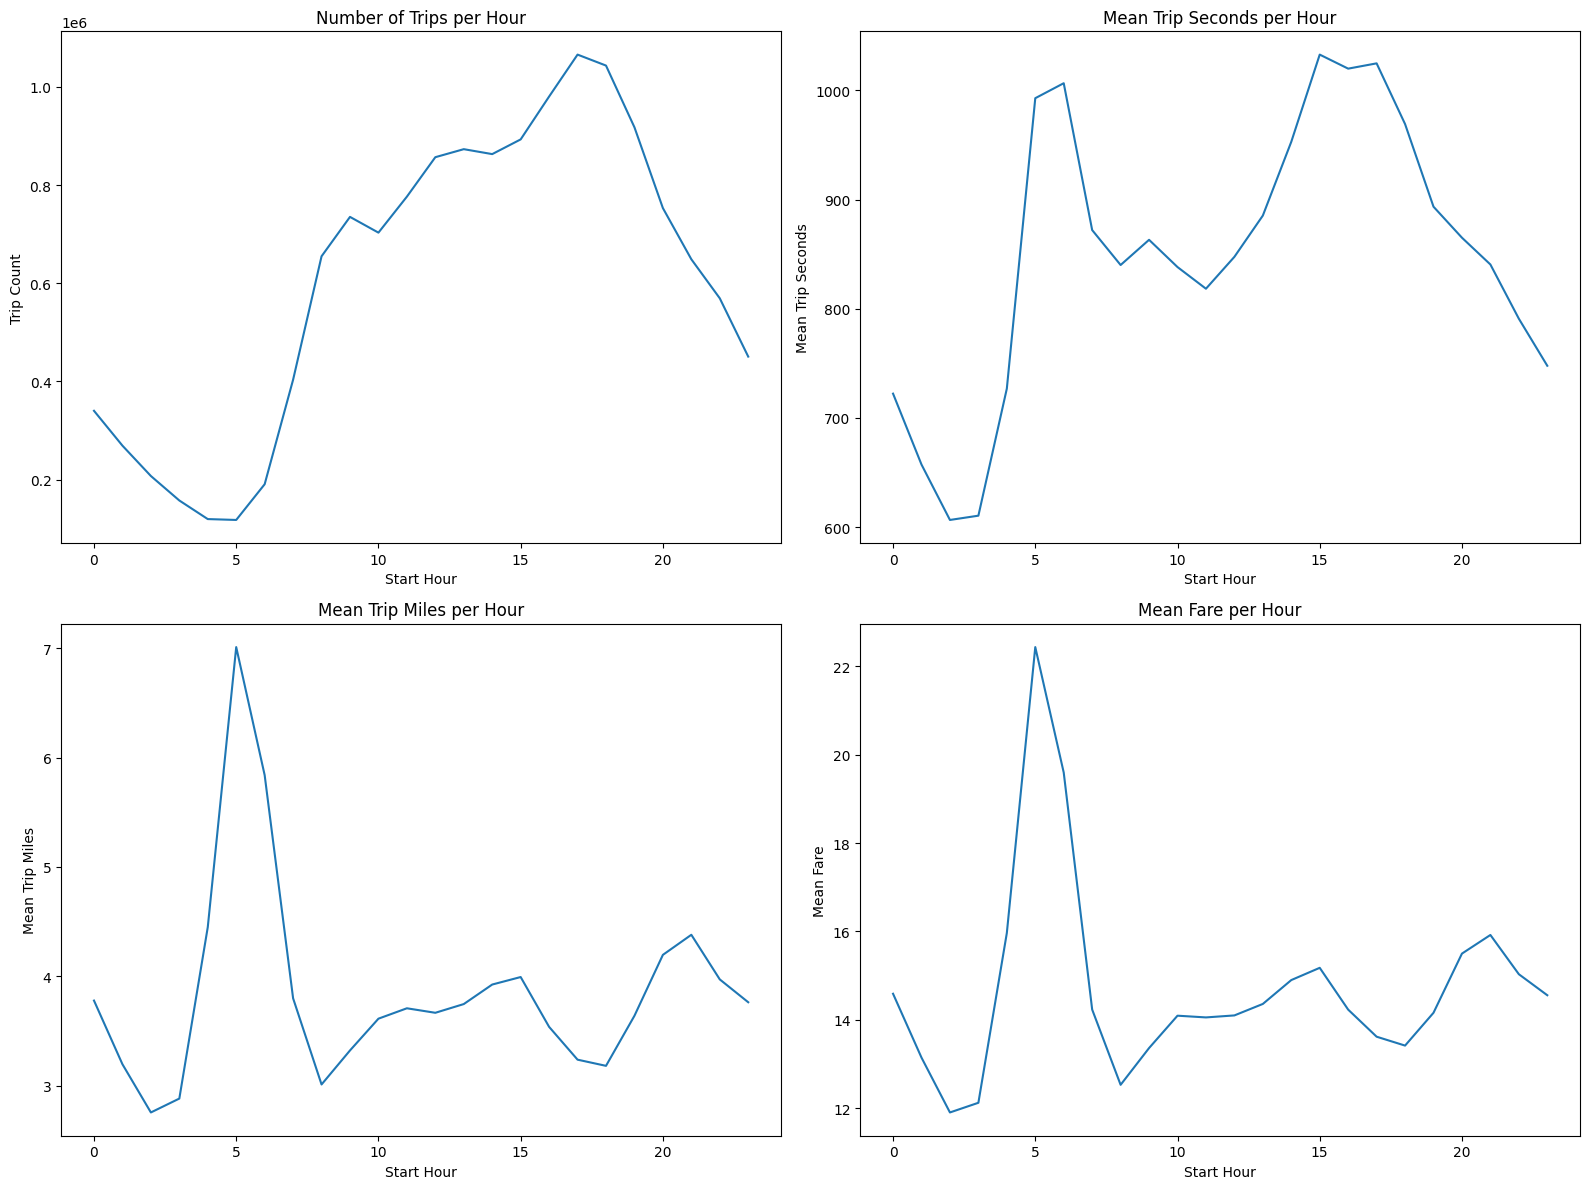

In [49]:
# group by 'start_hour' and aggregate
aggregated_data = {
    'Trip Count': taxi_trips_df.groupby('start_hour').size().reset_index(name='trip_count'),
    'Mean Trip Seconds': taxi_trips_df.groupby('start_hour')['trip_seconds'].mean().reset_index(name='mean_trip_seconds'),
    'Mean Trip Miles': taxi_trips_df.groupby('start_hour')['trip_miles'].mean().reset_index(name='mean_trip_miles'),
    'Mean Fare': taxi_trips_df.groupby('start_hour')['fare'].mean().reset_index(name='mean_fare')
}


fig, axs = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)

# titles and labels 
titles = ['Number of Trips per Hour', 'Mean Trip Seconds per Hour', 
          'Mean Trip Miles per Hour', 'Mean Fare per Hour']
y_labels = ['Trip Count', 'Mean Trip Seconds', 'Mean Trip Miles', 'Mean Fare']

# plot 
for ax, (key, data), title, y_label in zip(axs.ravel(), aggregated_data.items(), titles, y_labels):
    sns.lineplot(data=data, x='start_hour', y=data.columns[1], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Start Hour')
    ax.set_ylabel(y_label)

plt.show()

The following can be derived from these line plots: 
- There is a spike in trip miles in the morning. These could be commuters going to work. 
- However, there is no twin peak (or at least not as drastic) that indicates people coming off work. This might be because the time people get off work spreads more. 
- There are two spikes in seconds that do not go in hand with the trip miles. They indicate high traffic during rush hours. 
- While the longest trips are in the morning, the most trips are done in the evening. 

<Axes: xlabel='start_hour', ylabel='trip_count'>

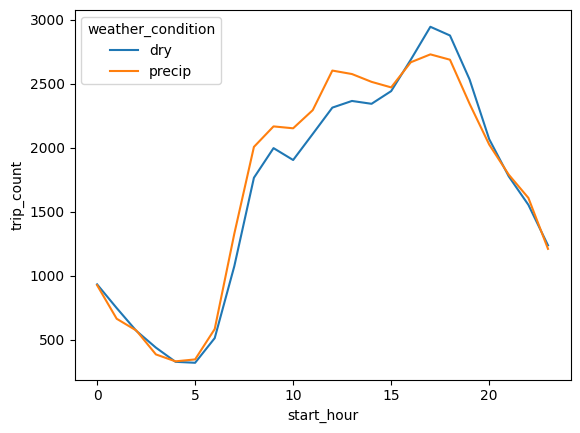

In [50]:
taxi_trips_df['weather_condition'] = taxi_trips_df['precip'].apply(lambda x: 'dry' if x == 0 else 'precip')

hourly_weather_counts = taxi_trips_df.groupby(['start_hour', 'weather_condition']).size().reset_index(name='trip_count')

# count the number of unique days 
day_counts = taxi_trips_df.groupby(['start_hour', 'weather_condition'])['date'].nunique().reset_index(name='day_count')

# merge to get the number of days for each group
hourly_weather_counts = hourly_weather_counts.merge(day_counts, on=['start_hour', 'weather_condition'])

# normalize trip counts by number of days
hourly_weather_counts['trip_count'] = hourly_weather_counts['trip_count'] / hourly_weather_counts['day_count']

# plot 
sns.lineplot(data=hourly_weather_counts, x='start_hour', y='trip_count', hue='weather_condition')

The trip counts were normalized by the number of days in each temperature category to provide a more accurate comparison. This will account for the fact that some temperature categories might have more days than others, which could skew the raw trip counts.

The trip count slightly higher when it is wet, however, this is not true for peak demand hours in the evening. 

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_27212/3862846140.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_temp_means = taxi_trips_df.groupby(['start_hour', 'temp_category']).size().reset_index(name='trip_count')
/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_27212/3862846140.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_counts = taxi_trips_df.groupby(['start_hour', 'temp_category'])['date'].nunique().reset_index(name='day_count')


<Axes: xlabel='start_hour', ylabel='trip_count'>

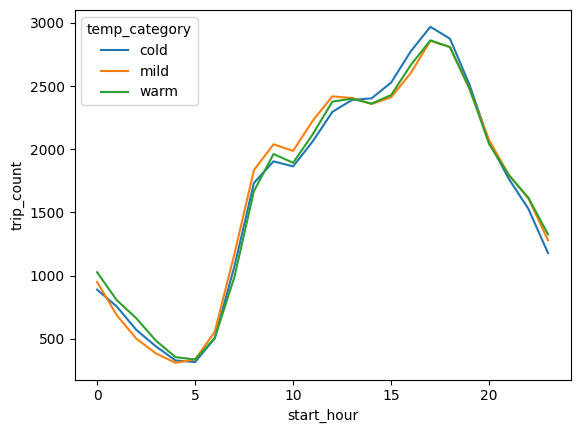

In [51]:
# define temperature bins
bins = [0, 10, 20, np.inf] 
# labels for the bins
labels = ['cold', 'mild', 'warm'] 
taxi_trips_df['temp_category'] = pd.cut(taxi_trips_df['temp'], bins=bins, labels=labels)

# aggregate data
hourly_temp_means = taxi_trips_df.groupby(['start_hour', 'temp_category']).size().reset_index(name='trip_count')

# count for normalizing
day_counts = taxi_trips_df.groupby(['start_hour', 'temp_category'])['date'].nunique().reset_index(name='day_count')

# merge data
hourly_temp_means = hourly_temp_means.merge(day_counts, on=['start_hour', 'temp_category'])

# normalize the trip counts by the number of days
hourly_temp_means['trip_count'] = hourly_temp_means['trip_count'] / hourly_temp_means['day_count']

# plot
sns.lineplot(data=hourly_temp_means, x='start_hour', y='trip_count', hue='temp_category')

The temperature has not much impact on when people used taxis. 

## Weekday Analysis
It might be interesting to see whether there are fluctuations during the week, especially weekdays vs weekend. 

In [52]:
# aggregate important features 
aggregated_df_weekday = taxi_trips_df.groupby('start_weekday').agg(
    count_of_rows=('start_day', 'size'),
    mean_trip_miles=('trip_miles', 'mean'),
    mean_trip_fare=('fare', 'mean'),
    mean_trip_seconds=('trip_seconds', 'mean'),
    mean_temp = ('temp', 'mean'),
    mean_precip = ('precip', 'mean')
).reset_index()

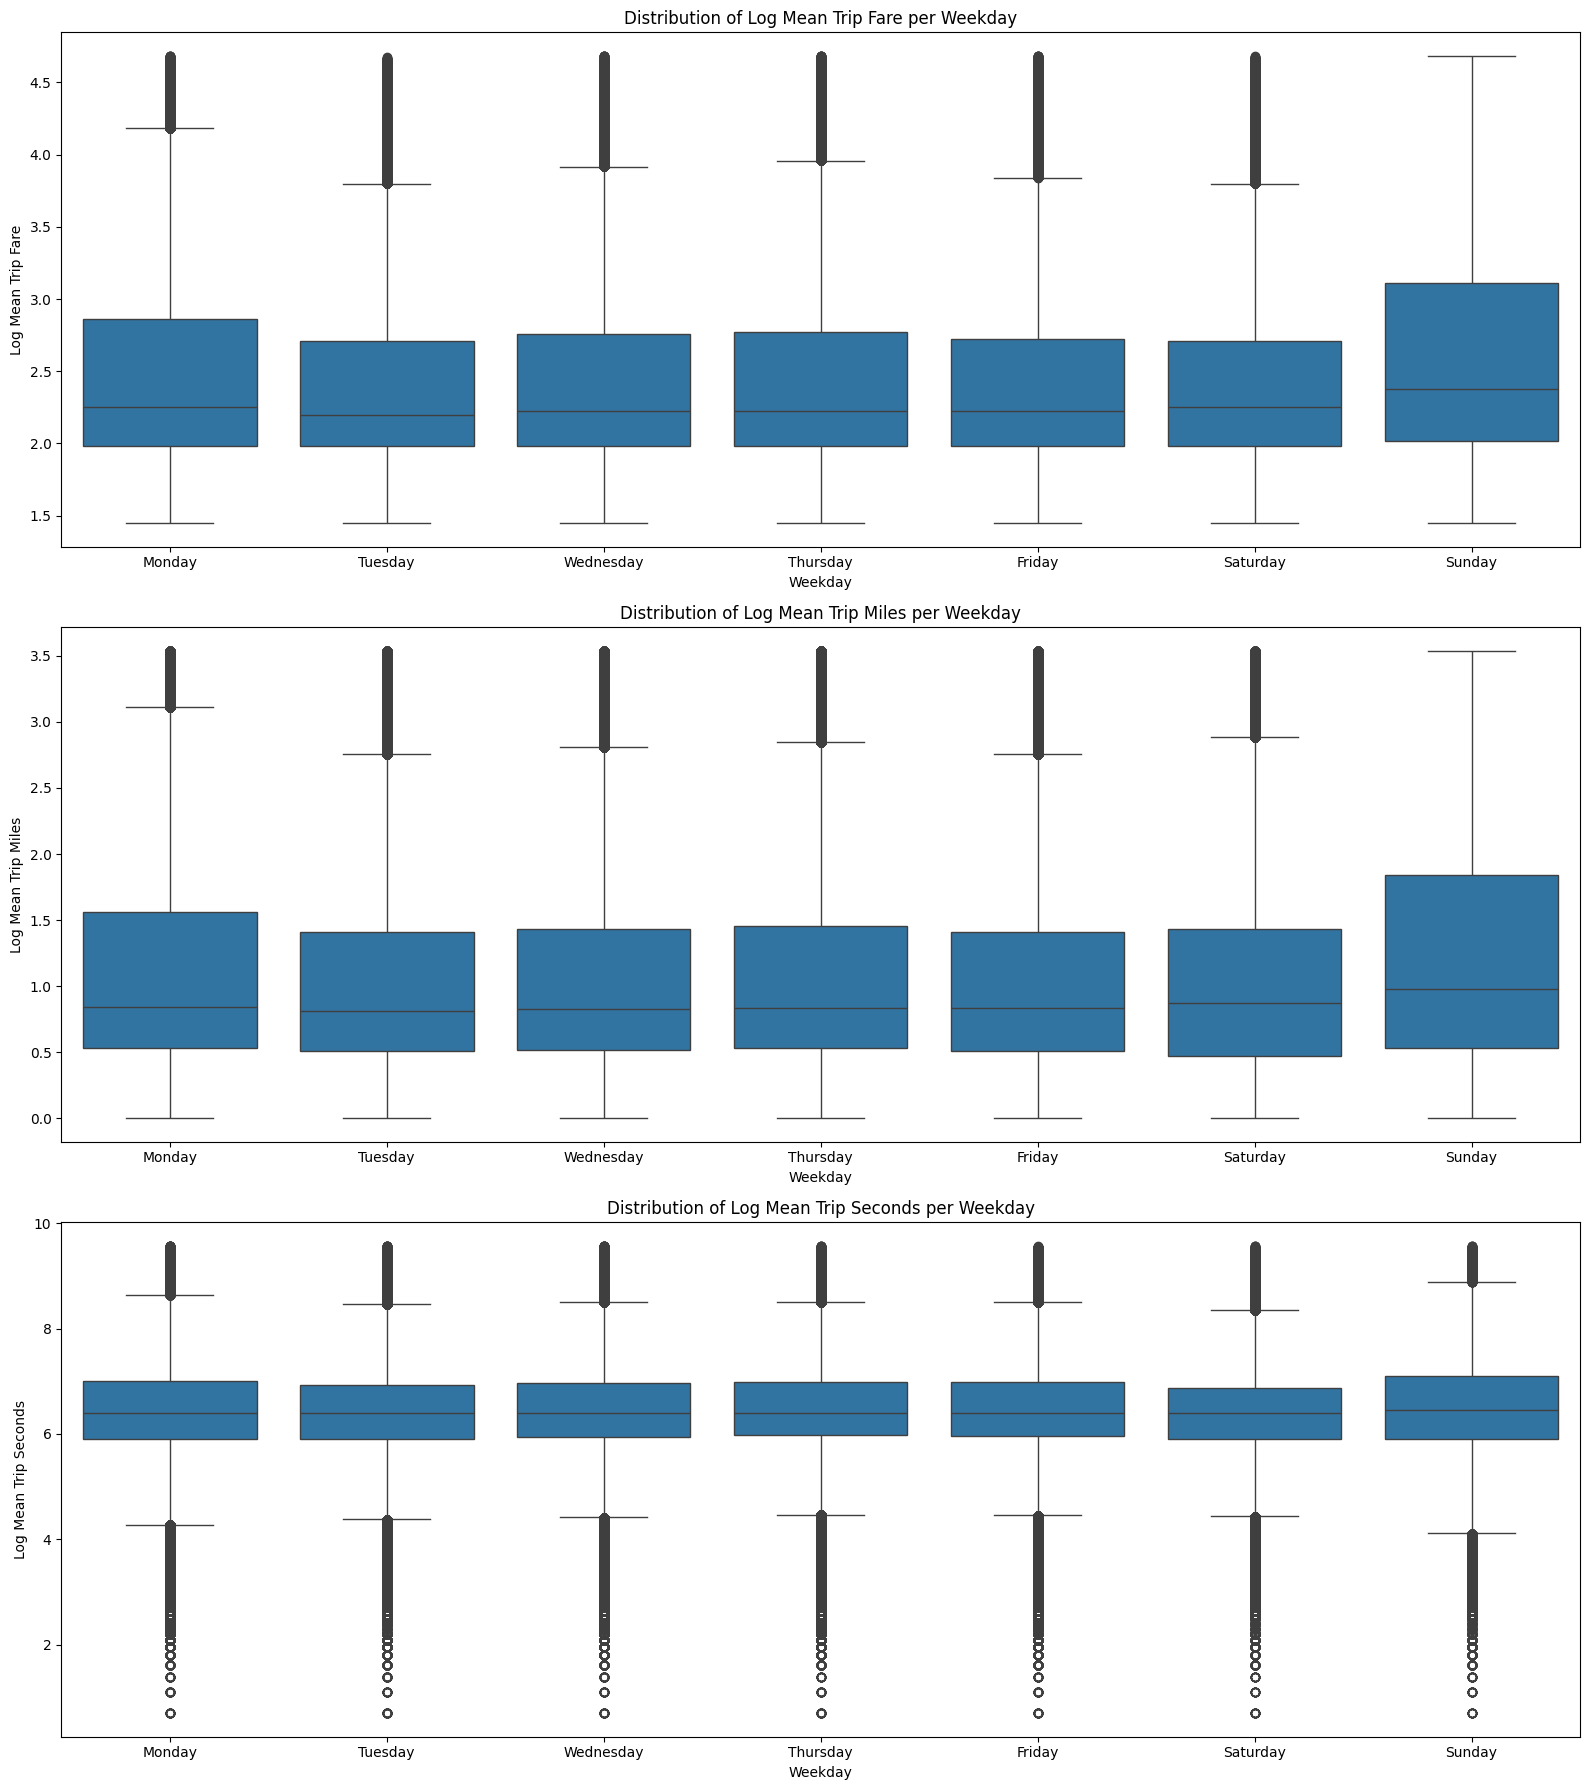

In [53]:
# apply a logarithmic transformation 
taxi_trips_df['log_mean_trip_fare'] = np.log1p(taxi_trips_df['fare'])
taxi_trips_df['log_mean_trip_miles'] = np.log1p(taxi_trips_df['trip_miles'])
taxi_trips_df['log_mean_trip_seconds'] = np.log1p(taxi_trips_df['trip_seconds'])

# create a list variables
log_variables = ['log_mean_trip_fare', 'log_mean_trip_miles', 'log_mean_trip_seconds']


fig, axs = plt.subplots(len(log_variables), 1, figsize=(16, 18), tight_layout=True)

# plot
for i, var in enumerate(log_variables):
    sns.boxplot(x='start_weekday', y=var, data=taxi_trips_df, ax=axs[i])
    axs[i].set_title(f'Distribution of {var.replace("_", " ").title()} per Weekday')
    axs[i].set_xlabel('Weekday')
    axs[i].set_ylabel(var.replace("_", " ").title())
    
   
    axs[i].set_xticks(range(7))  
    axs[i].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()


Sunday stands out as the day with higher and more variable trip fares, distances, and durations. The distributions from Monday to Saturday are relatively similar, suggesting that travel behavior is more consistent during the workweek.

## Weekday X Starttime Analysis (using different time intervals)

In [54]:
# aggregate important features 
aggregated_df_weekday_hour = taxi_trips_df.groupby(['start_weekday', 'hour']).agg(
    count_of_rows=('start_day', 'size'),
    mean_trip_miles=('trip_miles', 'mean'),
    mean_trip_fare=('fare', 'mean'),
    mean_trip_seconds=('trip_seconds', 'mean'),
    mean_temp=('temp', 'mean'),
    mean_precip=('precip', 'mean'),
    mean_idle_time=('idle_seconds', 'mean')
).reset_index()

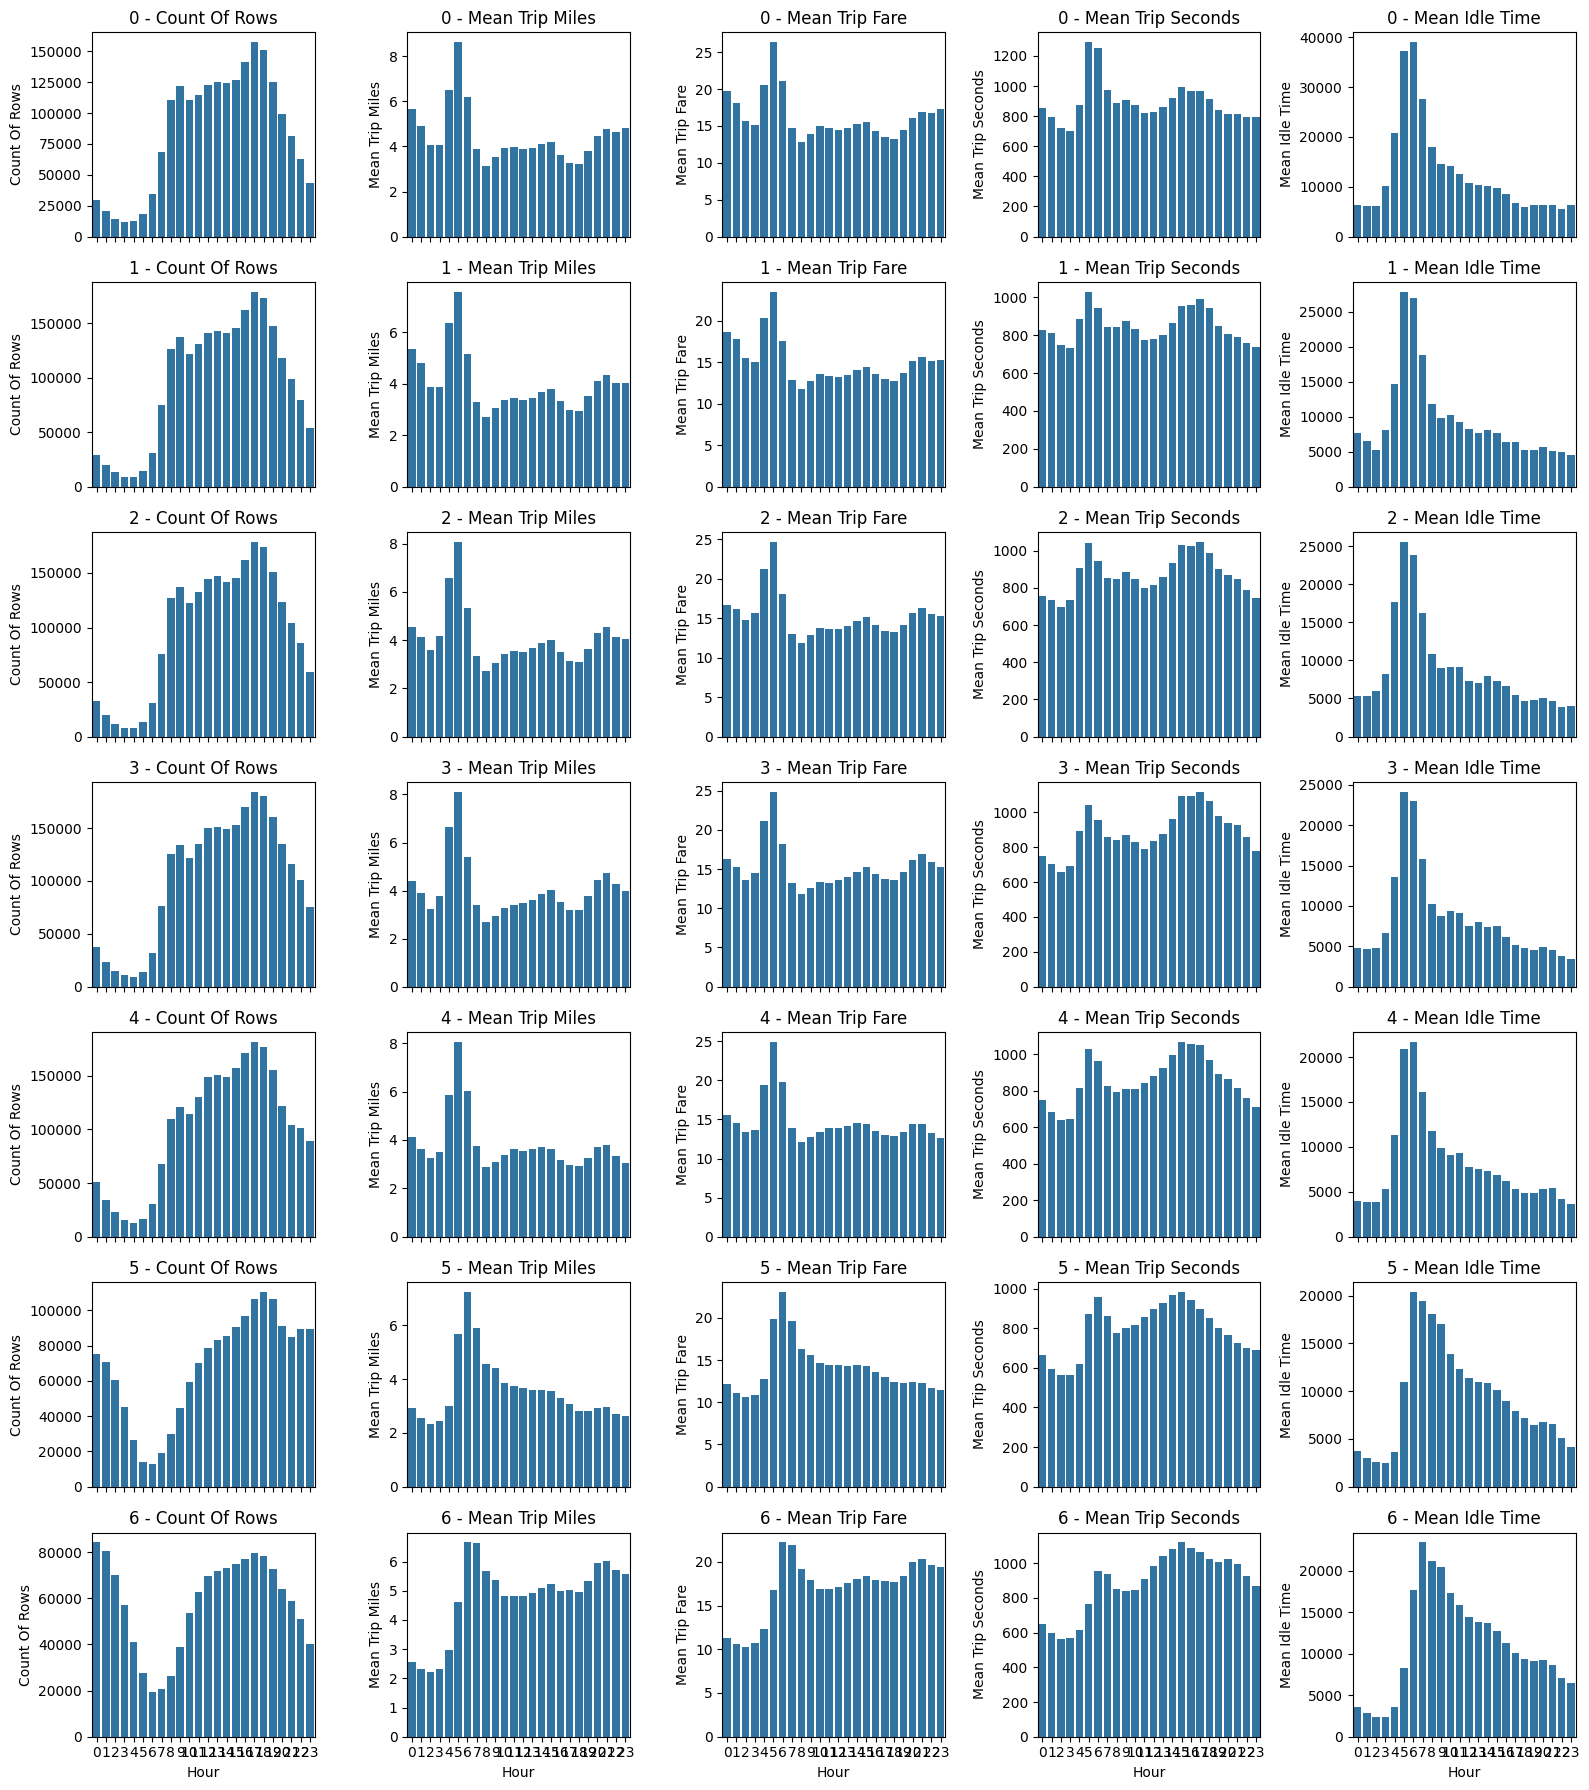

In [55]:
# list of variables to plot
variables = ['count_of_rows', 'mean_trip_miles', 'mean_trip_fare', 'mean_trip_seconds', 'mean_idle_time']

fig, axs = plt.subplots(7, len(variables), figsize=(16, 18), sharex=True)

# Weekday names
weekdays = [0,1,2,3,4,5,6]

# plot each variable for each weekday
for i, weekday in enumerate(weekdays):
    weekday_data = aggregated_df_weekday_hour[aggregated_df_weekday_hour['start_weekday'] == weekday]
    
    for j, var in enumerate(variables):
        sns.barplot(x='hour', y=var, data=weekday_data, ax=axs[i, j])
        axs[i, j].set_title(f'{weekday} - {var.replace("_", " ").title()}')
        axs[i, j].set_xlabel('Hour')
        axs[i, j].set_ylabel(var.replace("_", " ").title())

plt.tight_layout()
plt.show()

The histograms lead to the following observations: 

- Across all days, trip counts are lowest during early morning hours and increase significantly from around 6 AM.
On weekends,  there is a noticeable shift with a later peak and extended activity in the evening and night hours.
- The average trip miles tends to be higher during early morning hours across all days and decreases during the day, with some variation. 
On weekdays, there’s a midday dip, possibly reflecting shorter trips during lunch hours. On weekends, the pattern is more stable throughout the day, with slightly longer trips during the night. The fare pattern is again, highly correlated with the trip miles
- The trip seconds have two peaks, indicating high traffic during commuting hours. 
On weekends, the variation in trip duration is more pronounced in the later hours, possibly due to different travel behaviors or conditions.
- Idle time is highest during the early morning hours (especially around midnight), gradually decreasing throughout the day. This trend reflects that taxis spend more time without passengers when demand is low (late at night or early morning).
The pattern shows that idle time is more significant on weekends, particularly on Saturday nights. 


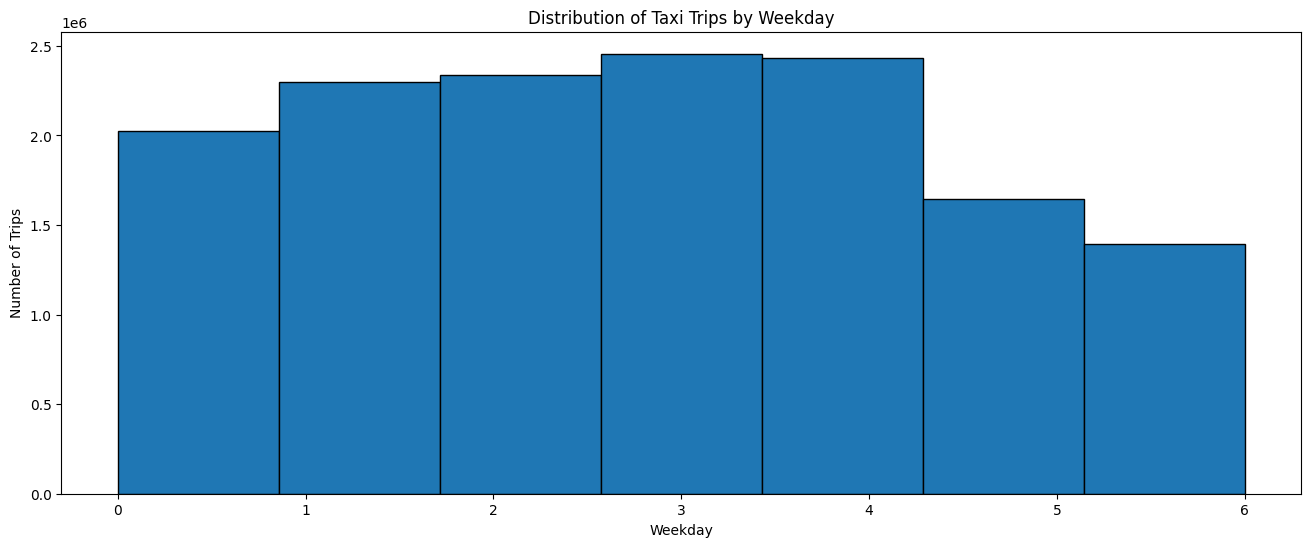

In [56]:
# show distribution by weekday
plt.figure(figsize=(16, 6))  # Optional: Set the figure size
plt.hist(taxi_trips_df['start_weekday'], bins=7, edgecolor='black')  # Create the histogram

# add titles and labels
plt.title('Distribution of Taxi Trips by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Trips')

# plot
plt.show()

There are fewer rides on weekends. 

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_62273/3948551326.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= taxi_trips_df.groupby(['start_weekday', 'start_time_4_hour_interval']).size().reset_index(name='count')


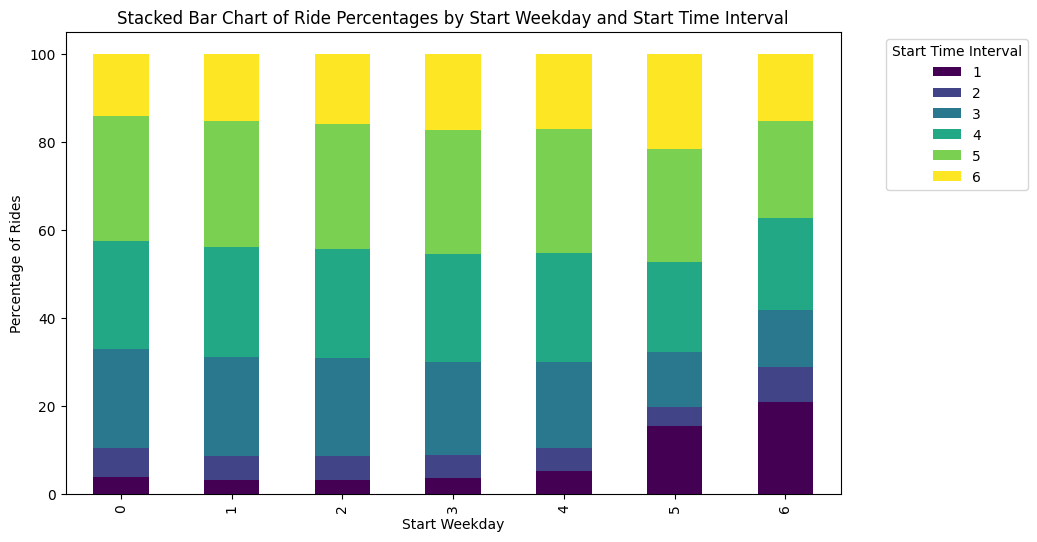

In [163]:
df= taxi_trips_df.groupby(['start_weekday', 'start_time_4_hour_interval']).size().reset_index(name='count')
pivot_df = df.pivot(index='start_weekday', columns='start_time_4_hour_interval', values='count')

# normalize the counts to percentages
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# plotting the stacked bar chart with percentages
ax = pivot_df_percentage.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='viridis')

plt.xlabel('Start Weekday')
plt.ylabel('Percentage of Rides')
plt.title('Stacked Bar Chart of Ride Percentages by Start Weekday and Start Time Interval')
plt.legend(title='Start Time Interval', bbox_to_anchor=(1.05, 1), loc='upper left')

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_62273/3892254206.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= taxi_trips_df.groupby(['start_weekday', 'start_time_6_hour_interval']).size().reset_index(name='count')


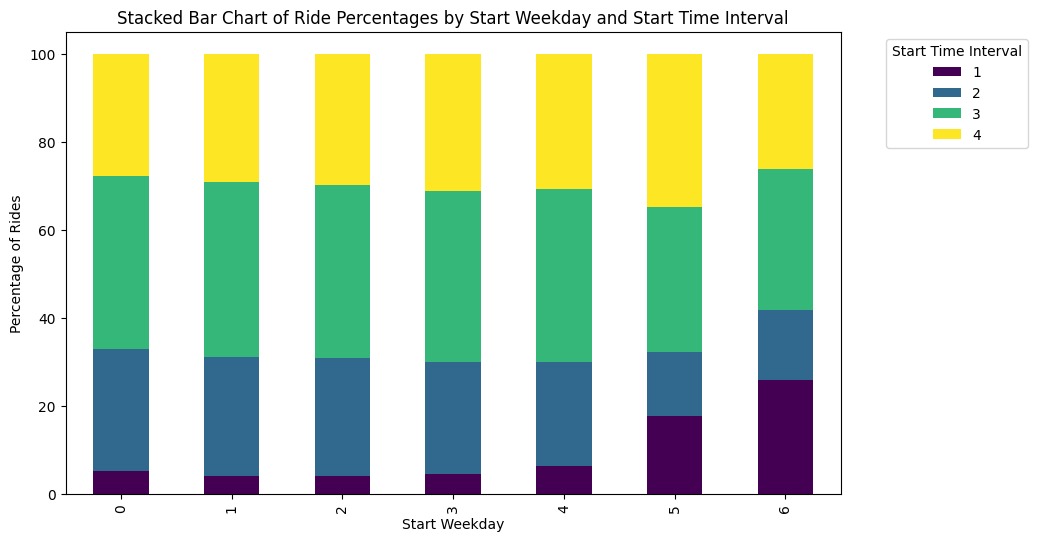

In [164]:
df= taxi_trips_df.groupby(['start_weekday', 'start_time_6_hour_interval']).size().reset_index(name='count')
pivot_df = df.pivot(index='start_weekday', columns='start_time_6_hour_interval', values='count')

# normalize the counts to percentages
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# plot stacked bar chart with percentages
ax = pivot_df_percentage.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='viridis')

plt.xlabel('Start Weekday')
plt.ylabel('Percentage of Rides')
plt.title('Stacked Bar Chart of Ride Percentages by Start Weekday and Start Time Interval')
plt.legend(title='Start Time Interval', bbox_to_anchor=(1.05, 1), loc='upper left')

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_62273/2857254221.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= taxi_trips_df.groupby(['start_weekday', 'start_time_2_hour_interval']).size().reset_index(name='count')


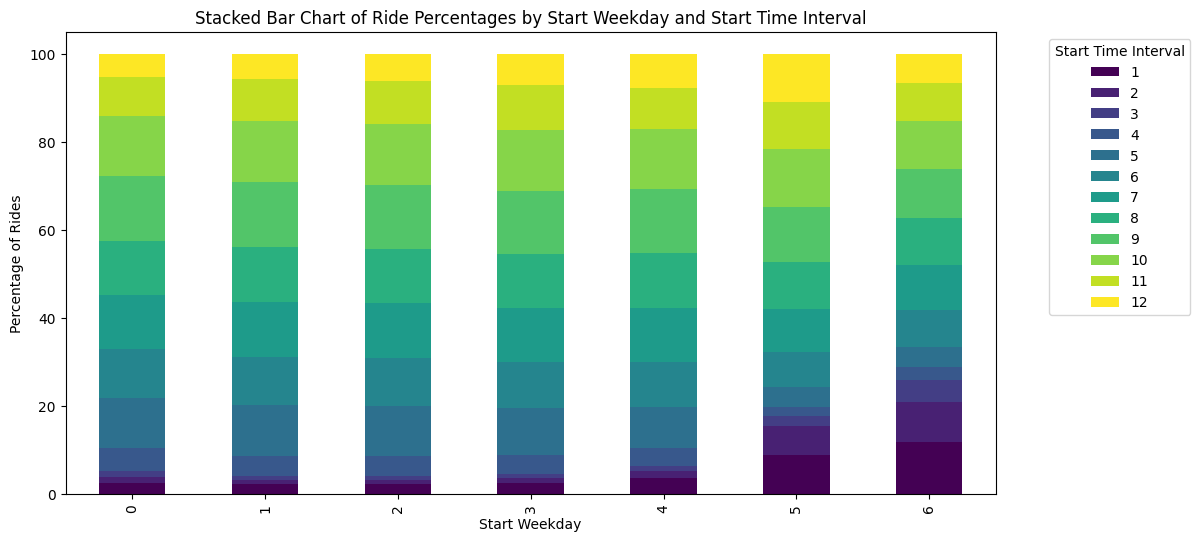

In [165]:
df= taxi_trips_df.groupby(['start_weekday', 'start_time_2_hour_interval']).size().reset_index(name='count')
pivot_df = df.pivot(index='start_weekday', columns='start_time_2_hour_interval', values='count')

# normalize counts to percentages
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# plot stacked bar chart with percentages
ax = pivot_df_percentage.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='viridis')

plt.xlabel('Start Weekday')
plt.ylabel('Percentage of Rides')
plt.title('Stacked Bar Chart of Ride Percentages by Start Weekday and Start Time Interval')
plt.legend(title='Start Time Interval', bbox_to_anchor=(1.05, 1), loc='upper left')

These stacked bar charts prove that for the weekends, the evening/night and early morning are times with most demand. 


## 3 - Geospatial Analysis

In the end, we want to look at a combination of temporal and spatial feature, focusing on the most important areas, as we already established that they account for around half of the trips. 

In [57]:
top_10_pickup = trip_counts_starting.nlargest(10, 'census_count')['census']
top_10_dropoff = trip_counts_ending.nlargest(10, 'census_count')['census']

In [58]:
pickup_df = taxi_trips_df[taxi_trips_df['pickup_census'].isin(top_10_pickup)]
dropoff_df = taxi_trips_df[taxi_trips_df['dropoff_census'].isin(top_10_dropoff)]

# combine pickup and dropoff data
combined_df = pd.concat([pickup_df, dropoff_df])

In [60]:
# for pickups
pickup_hourly_counts = (pickup_df.groupby(['pickup_census', pickup_df['start_hour']])
                        .size()
                        .reset_index(name='count'))

# for dropoffs
dropoff_hourly_counts = (dropoff_df.groupby(['dropoff_census', dropoff_df['end_hour']])
                         .size()
                         .reset_index(name='count'))

# for pickups
pickup_weekday_counts = (pickup_df.groupby(['pickup_census', pickup_df['start_weekday']])
                        .size()
                        .reset_index(name='count'))

# for dropoffs
dropoff_weekday_counts = (dropoff_df.groupby(['dropoff_census', dropoff_df['end_weekday']])
                         .size()
                         .reset_index(name='count'))

# for pickups
pickup_week_counts = (pickup_df.groupby(['pickup_census', pickup_df['start_week']])
                        .size()
                        .reset_index(name='count'))

# for dropoffs
dropoff_week_counts = (dropoff_df.groupby(['dropoff_census', dropoff_df['end_week']])
                         .size()
                         .reset_index(name='count'))



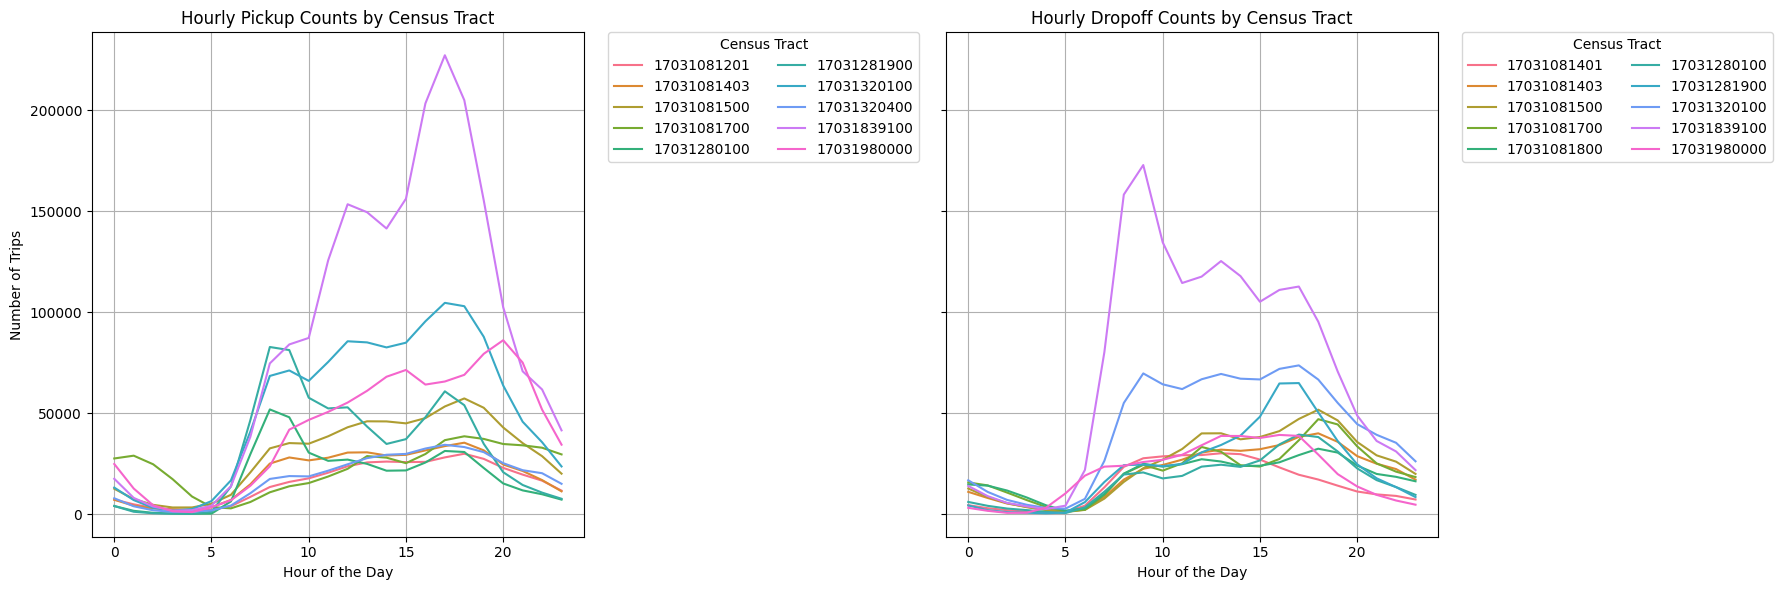

In [61]:
data_info = {
    'Pickup': (pickup_hourly_counts, 'start_hour', 'pickup_census'),
    'Dropoff': (dropoff_hourly_counts, 'end_hour', 'dropoff_census')
}

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# loop through data to create plots
for (title, (df, x_col, hue)), ax in zip(data_info.items(), axes):
    num_census_tracts = df[hue].nunique()
    palette = sns.color_palette("husl", num_census_tracts)
    
    sns.lineplot(data=df, x=x_col, y='count', hue=hue, palette=palette, ax=ax)
    ax.set(title=f'Hourly {title} Counts by Census Tract', xlabel='Hour of the Day', ylabel='Number of Trips')
    ax.grid(True)
    ax.legend(title='Census Tract', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)

plt.tight_layout()

# plot
plt.show()

Location Codes:**
City Centre (The Loop): `17031839100`
O'Hare Airport: `17031980000`

O'Hare:
Pickup: Increasing demand throughout the day.
Dropoffs: Decline in the evening.
Due to high demand in pickups, consider redirecting more vehicles to this area during peak times.

City Centre:
Pickup: Gradual rise, peaking in the evening.
Dropoffs: Higher earlier in the day.
Ensure vehicle availability in the evening when pickup demand peaks.


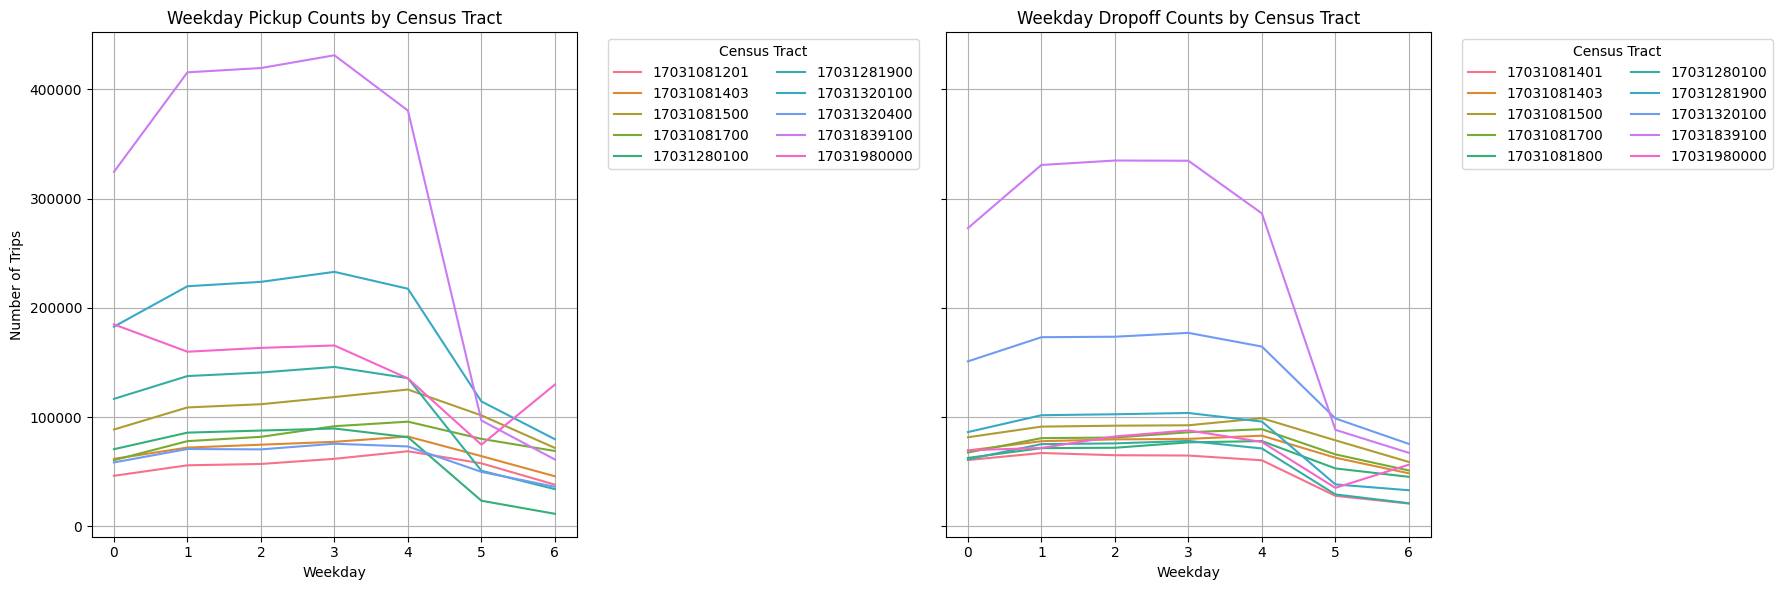

In [62]:
data_info = {
    'Pickup': (pickup_weekday_counts, 'start_weekday', 'pickup_census'),
    'Dropoff': (dropoff_weekday_counts, 'end_weekday', 'dropoff_census')
}

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# loop through the data to create plots
for (title, (df, x_col, hue)), ax in zip(data_info.items(), axes):
    num_census_tracts = df[hue].nunique()
    palette = sns.color_palette("husl", num_census_tracts)
    
    sns.lineplot(data=df, x=x_col, y='count', hue=hue, palette=palette, ax=ax)
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Number of Trips')
    ax.set_title(f'Weekday {title} Counts by Census Tract')
    ax.grid(True)
    ax.legend(title='Census Tract', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.tight_layout()

# plot
plt.show()

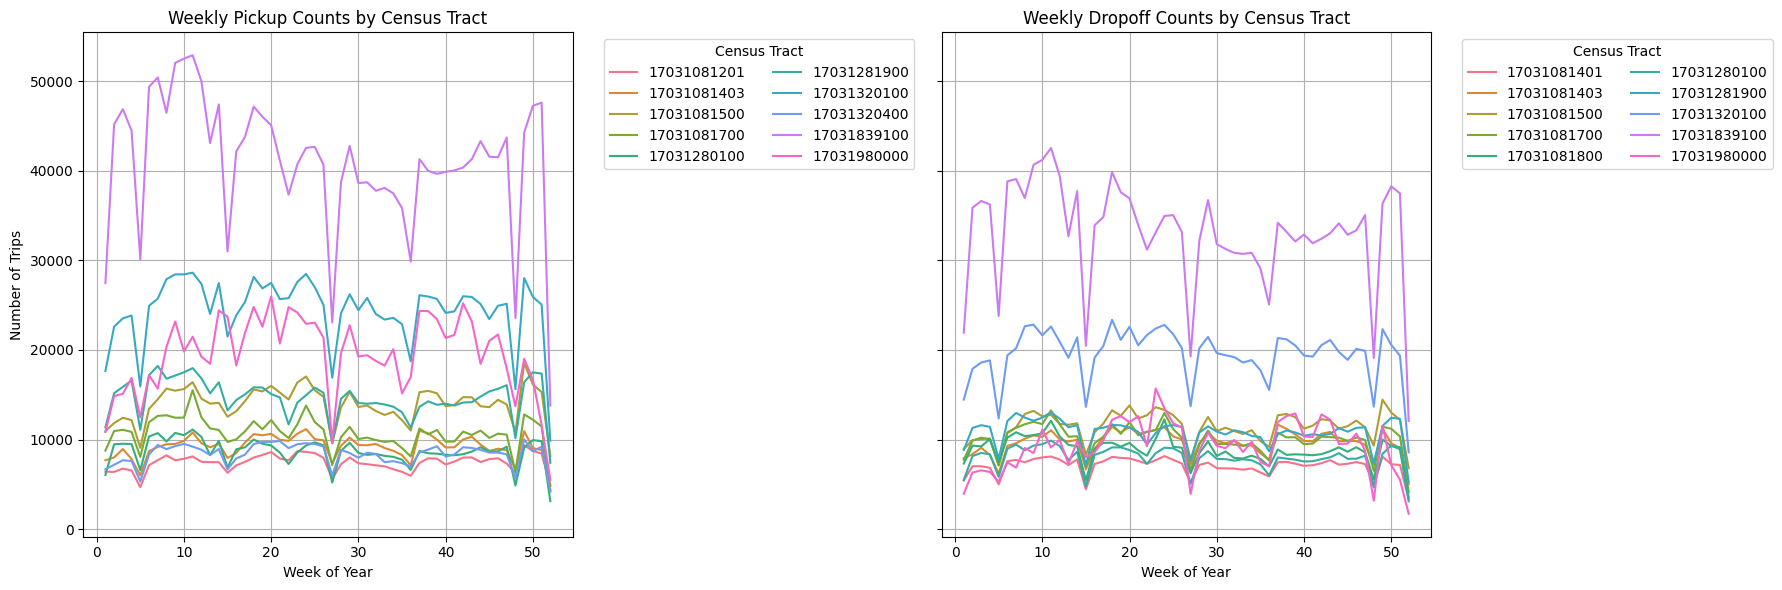

In [63]:
data_info = {
    'Pickup': (pickup_week_counts, 'start_week', 'pickup_census'),
    'Dropoff': (dropoff_week_counts, 'end_week', 'dropoff_census')
}

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# loop through data to create plots
for (title, (df, x_col, hue)), ax in zip(data_info.items(), axes):
    num_census_tracts = df[hue].nunique()
    palette = sns.color_palette("husl", num_census_tracts)
    
    sns.lineplot(data=df, x=x_col, y='count', hue=hue, palette=palette, ax=ax)
    ax.set_xlabel('Week of Year')
    ax.set_ylabel('Number of Trips')
    ax.set_title(f'Weekly {title} Counts by Census Tract')
    ax.grid(True)
    ax.legend(title='Census Tract', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.tight_layout()

# plot
plt.show()

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_27212/1697661023.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = taxi_trips_df.groupby(['start_time_6_hour_interval', 'pickup_census']).size().reset_index(name='trip_count')


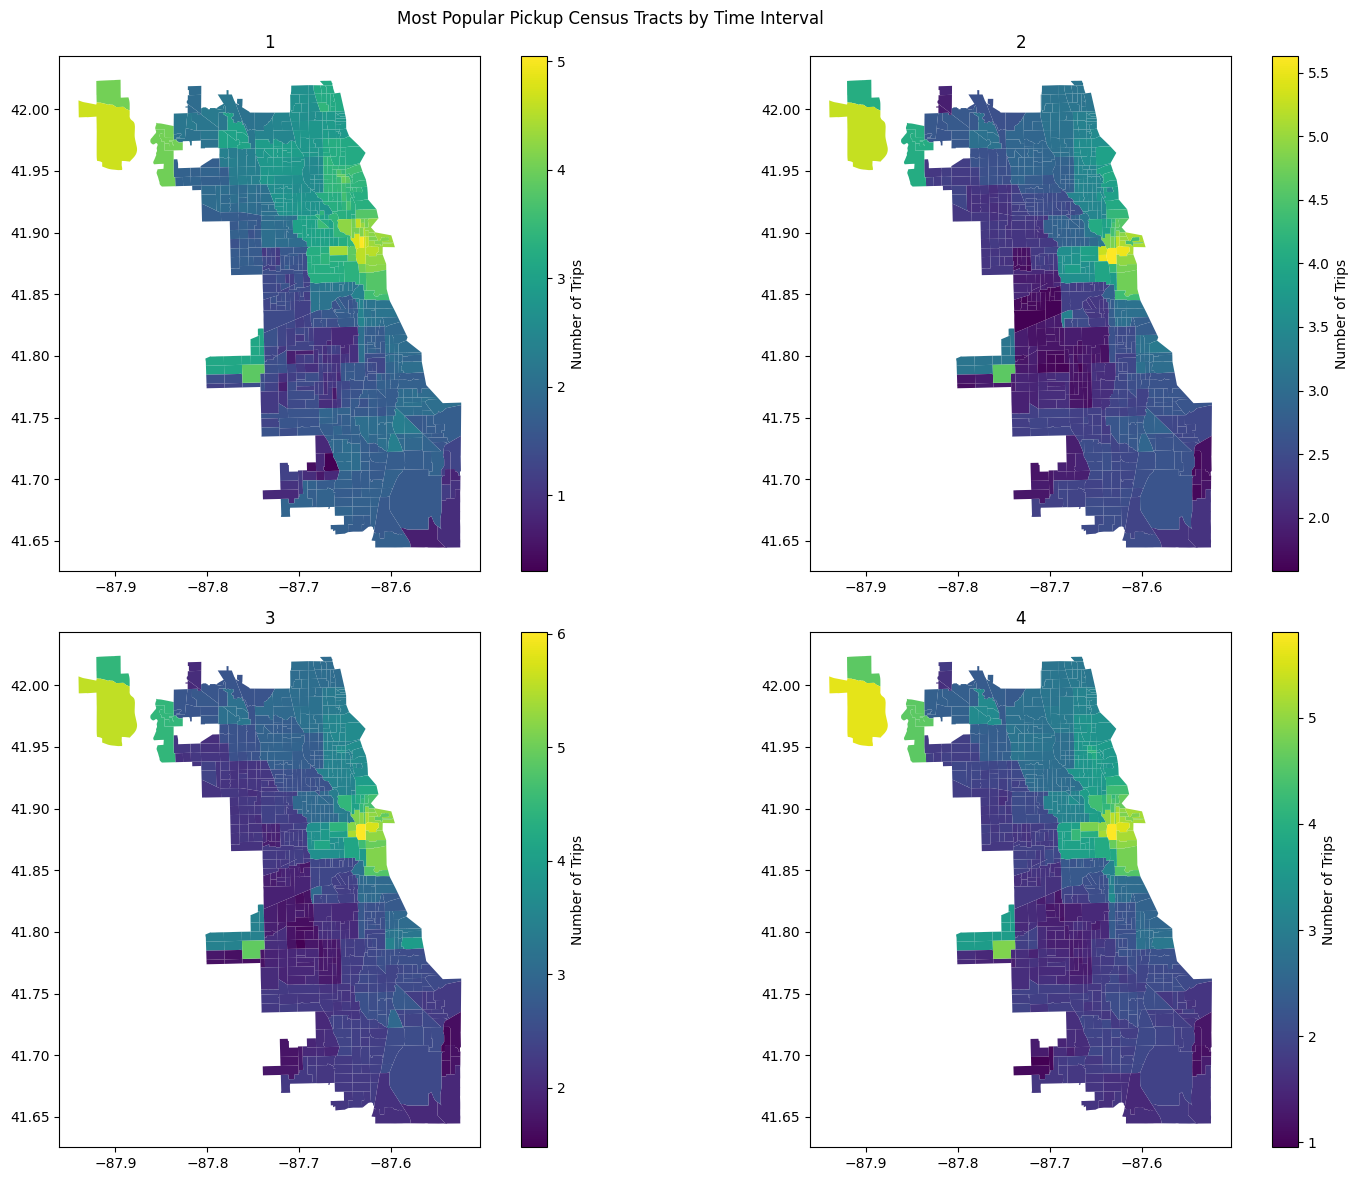

In [64]:
# aggregate by time interval and census tract
agg_data = taxi_trips_df.groupby(['start_time_6_hour_interval', 'pickup_census']).size().reset_index(name='trip_count')
agg_data['log_trip_count'] = np.log10(agg_data['trip_count'])

# unique intervals
intervals = agg_data['start_time_6_hour_interval'].unique()

agg_data = pd.merge(agg_data, boundaries[['census', 'geometry']], left_on="pickup_census", right_on='census', how='left')
agg_data = gpd.GeoDataFrame(agg_data, geometry="geometry")

# create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Most Popular Pickup Census Tracts by Time Interval')

for i, interval in enumerate(intervals):
    ax = axes[i // 2, i % 2]
    
    interval_data = agg_data[agg_data['start_time_6_hour_interval'] == interval]
    
   
    interval_data.plot(column='log_trip_count', cmap='viridis', legend=True,
                       legend_kwds={'label': "Number of Trips"}, ax=ax)
    
    ax.set_title(f'{interval}')

plt.tight_layout()  
plt.show()